In [1]:
%reload_ext autoreload
%autoreload 2

In [4]:
from peptdeep.pretrained_models import ModelManager
from peptdeep import settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import sklearn.metrics as sk
import sklearn.linear_model as sk_lm
from alphabase.psm_reader import psm_reader_provider

c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_base = pd.read_csv("evidence_freshfrozen_base.txt",  sep="\t")

C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\2468220614.py:1: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_base = pd.read_csv("evidence_freshfrozen_base.txt",  sep="\t")


In [3]:
# split df into the 3 Experiments
df = df_base
df_51 = df[df["Experiment"]=='P064051']
df_64 = df[df["Experiment"]=='P064064']
df_28 = df[df["Experiment"]=='P064428']

# Load Model

# Transfer Learning

## Training

In [5]:
# imprved sampling
n = 10000

# ensure same quantity of experiments

# calculate the numbers for each experiment
n_51 = round((len(df_51)/len(df))*n)
n_64 = round((len(df_64)/len(df))*n)
n_28 = round((len(df_28)/len(df))*n)

df_51 = df_51.sample(n = n_51, random_state =  42)
df_64 = df_64.sample(n = n_64, random_state = 42)
df_28 = df_28.sample(n=n_28, random_state = 42)

df_train = pd.concat(objs=[df_51, df_64, df_28])
print(len(df_train))


9999


In [6]:
# turn training df into alpha base format
df_train.loc[:,'Original index'] = df_train.index
# run AlphaBase
mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.column_mapping['Original index'] = 'Original index'
mq_reader._translate_columns(df_train)
mq_reader._transform_table(df_train)
mq_reader._translate_decoy(df_train)
mq_reader._translate_score(df_train)
mq_reader._load_modifications(df_train)
mq_reader._translate_modifications()
mq_reader._post_process(df_train)  
df_train_ab = mq_reader.psm_df

In [7]:
models = ModelManager(device = 'gpu')
models.load_installed_models()

c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\cuda\__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
models.train_ccs_model(df_train_ab)

2024-08-09 15:31:10> 9420 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


## Testing

In [9]:
# turn training df into alpha base format
df_mq = df_base
df_mq.loc[:,'Original index'] = df_mq.index
# run AlphaBase
mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.column_mapping['Original index'] = 'Original index'
mq_reader._translate_columns(df_mq)
mq_reader._transform_table(df_mq)
mq_reader._translate_decoy(df_mq)
mq_reader._translate_score(df_mq)
mq_reader._load_modifications(df_mq)
mq_reader._translate_modifications()
mq_reader._post_process(df_mq)  
df_ab = mq_reader.psm_df

In [10]:
# predict whole dataset
prediction = models.predict_mobility(df_ab)

2024-08-09 15:40:24> Predicting mobility ...


100%|██████████| 46/46 [13:53<00:00, 18.12s/it]


In [11]:
prediction.to_csv('predictions/pred_trans_v2', sep = '\t')

In [13]:
# merging alpha base format back to MaxQuant
#df_ab = pd.read_csv('comparisons/comp_all_trans.txt', sep = '\t')
df_ab = prediction
df_comp = df_base
df_comp['ccs_pred'] = df_ab['ccs_pred']
df_comp['mobility_pred'] = df_ab['mobility_pred']
mapping_dict = {
            'sequence': 'Sequence',
            'charge': 'Charge',
            'rt': 'Retention time',
            'ccs': 'CCS',
            'mobility': '1/K0',
            'scan_num': 'MS/MS scan number',
            'raw_name': 'Raw file',
            'precursor_mz': 'm/z',
            'score': 'Score',
            'proteins': 'Proteins',
            'genes': 'Gene names',
            'decoy': 'Reverse',
            'intensity': 'Intensity',
            'nAA':'Length'}
merging_list = ['Sequence', 'Charge', 'CCS', 'Score', 'Length', 'Retention time', 'Proteins', 'Gene names','1/K0' , 'MS/MS scan number', 'Raw file'
                                                  , 'm/z', 'Intensity' ]
        # rename the columns of the alphabase dataframe according to the mapping dict
df_ab.rename(columns=mapping_dict, inplace=True)
        # set the original index as index
#df_ab.set_index('Original index', inplace=True)
df_merged = pd.merge( df_comp,df_ab, on = merging_list, how = 'inner')
df_merged.to_csv('comparisons/comp_trans_v2_orig.txt', sep = '\t')

In [14]:
df_merged.shape

(1396568, 82)

In [14]:
df_comp = pd.read_csv('comparisons/comp_trans_orig.txt', sep = '\t')

C:\Users\cocob\AppData\Local\Temp\ipykernel_1724\4069564456.py:1: DtypeWarning: Columns (62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comp = pd.read_csv('comparisons/comp_trans_orig.txt', sep = '\t')


In [15]:
df_pred = df_merged

In [16]:
df_pred['ccs_diff'] = np.subtract(df_pred['CCS'], df_pred['ccs_pred_y'])
df_pred['IM_diff'] = np.subtract(df_pred['1/K0'], df_pred['mobility_pred_y'])

Text(0.5, 1.0, 'Adjusted Error(Transfer Learning)')

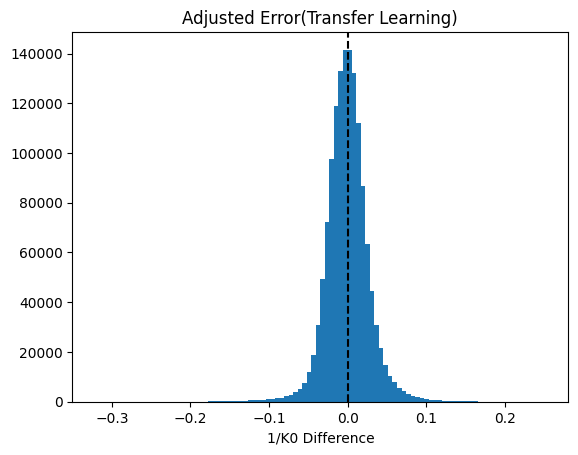

In [17]:
plt.hist(df_pred['IM_diff'], bins=100)
plt.axvline(x = 0.0, c = 'black', linestyle = '--')
plt.xlabel('1/K0 Difference')
plt.title('Adjusted Error(Transfer Learning)')

In [18]:
print(df_pred['ccs_diff'].mean())
print(df_pred['ccs_diff'].std())

-0.04253113038615202
15.00861947652307


In [19]:
print(df_pred['ccs_diff'].abs().mean())

9.791640217897543


In [20]:
# percentile of CCS Difference
perc_low = np.percentile(df_pred['ccs_diff'], 2.5)
perc_up = np.percentile(df_pred['ccs_diff'], 97.5)
print(f'({perc_low}, {perc_up})')


(-27.99451295541627, 30.585006258819966)


In [21]:
print((perc_low)*(-1)+perc_up)
window = (perc_low)*(-1)+perc_up

58.579519214236235


In [22]:
print(df_pred['IM_diff'].mean())
print(df_pred['IM_diff'].std())


-0.0001955223987797492
0.02718273232191789


In [23]:
# percentile of IM Difference
perc_low = np.percentile(df_pred['IM_diff'], 2.5)
perc_up = np.percentile(df_pred['IM_diff'], 97.5)
print(f'({perc_low}, {perc_up})')


(-0.05064467403963402, 0.055045556512901495)


In [27]:
print((perc_low)*(-1)+perc_up)
window = (perc_low)*(-1)+perc_up

0.10576335892733027


## Plots

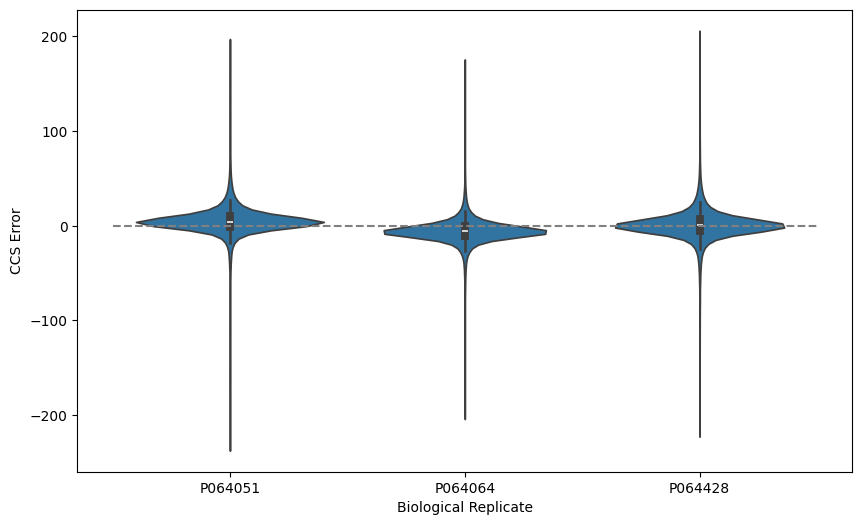

In [29]:
# violin plot: experiment vs CCS error
plt.figure(figsize=(10, 6))
sns.violinplot(x='Experiment', y='ccs_diff', data=df_pred, density_norm='count')

# Set plot labels and title
plt.xlabel('Biological Replicate')
plt.ylabel('CCS Error')
plt.hlines(y = 0.0, xmin = -0.5, xmax= 2.5, linestyles='--', colors='grey')

# Display the plot
plt.show()

In [24]:
print(df_pred[df_pred['Experiment']=='P064051']['ccs_diff'].mean())
print(df_pred[df_pred['Experiment']=='P064064']['ccs_diff'].mean())
print(df_pred[df_pred['Experiment']=='P064428']['ccs_diff'].mean())

4.73531471009093
-6.112668469125904
0.4689689057527973


In [26]:
print(df_pred[df_pred['Experiment']=='P064051']['IM_diff'].mean())
print(df_pred[df_pred['Experiment']=='P064064']['IM_diff'].mean())
print(df_pred[df_pred['Experiment']=='P064428']['IM_diff'].mean())

0.010125743870158733
-0.013422435898928227
0.0010187481750177417


2024-07-22 11:00:26> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


C:\Users\cocob\AppData\Local\Temp\ipykernel_22924\1662035779.py:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x='Fraction', y='ccs_diff', data=df_comp_trans, scale='count', width=1.0)


2024-07-22 11:00:28> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


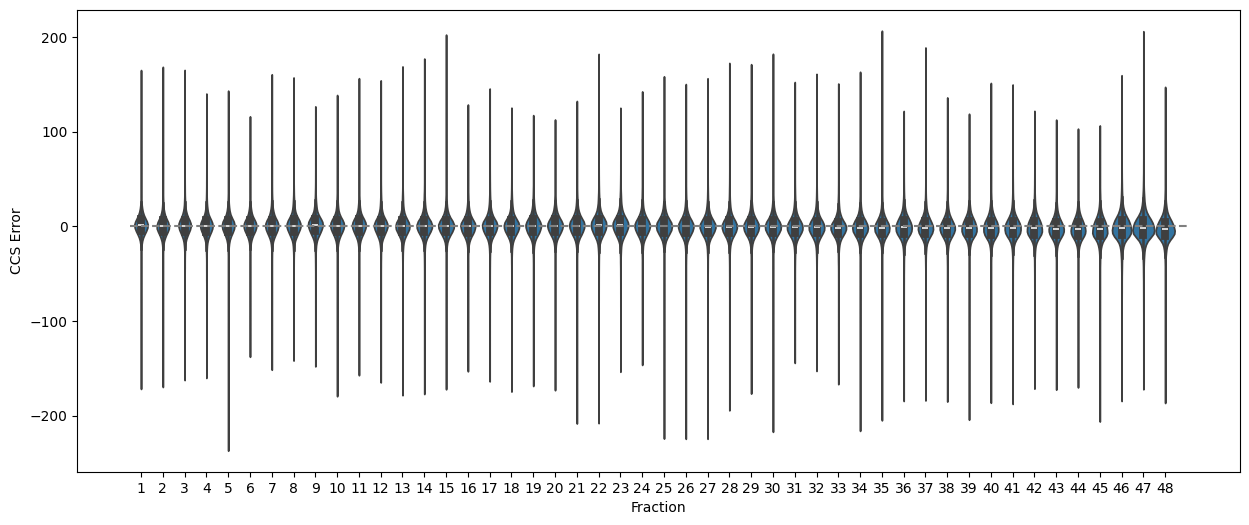

In [ ]:
# violin plot: fractions vs CCS error
plt.figure(figsize=(15, 6))
sns.violinplot(x='Fraction', y='ccs_diff', data=df_comp_trans, scale='count', width=1.0)

# Set plot labels and title
plt.xlabel('Fraction')
plt.ylabel('CCS Error')
plt.hlines(y = 0.0, xmin = -0.5, xmax= 48, linestyles='--', colors='grey')

# Display the plot
plt.show()

# Transfer Learning per Experiment

## Ex 51

In [4]:
df = df_51
df_train = df.sample(n = round(0.3*len(df)), random_state=42)
print(len(df_train))

151644


In [5]:
# turn training df into alpha base format
df_train.loc[:,'Original index'] = df_train.index
# run AlphaBase
mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.column_mapping['Original index'] = 'Original index'
mq_reader._translate_columns(df_train)
mq_reader._transform_table(df_train)
mq_reader._translate_decoy(df_train)
mq_reader._translate_score(df_train)
mq_reader._load_modifications(df_train)
mq_reader._translate_modifications()
mq_reader._post_process(df_train)  
df_train_ab = mq_reader.psm_df

In [ ]:
models = ModelManager(device = 'gpu')
models.load_installed_models()


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\cuda\__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
models.train_ccs_model(df_train_ab)

2024-08-13 11:21:31> 73325 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [ ]:
# turn complete df into alpha base format
df = df_51
df.loc[:,'Original index'] = df.index
# run AlphaBase
mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.column_mapping['Original index'] = 'Original index'
mq_reader._translate_columns(df)
mq_reader._transform_table(df)
mq_reader._translate_decoy(df)
mq_reader._translate_score(df)
mq_reader._load_modifications(df)
mq_reader._translate_modifications()
mq_reader._post_process(df)  
df_ab = mq_reader.psm_df

In [ ]:
prediction = models.predict_mobility(df_ab)

2024-07-26 13:21:29> Predicting mobility ...


100%|██████████| 46/46 [03:09<00:00,  4.13s/it]


C:\Users\cocob\AppData\Local\Temp\ipykernel_20332\186192150.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_20332\186192150.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


0.7166750072460729


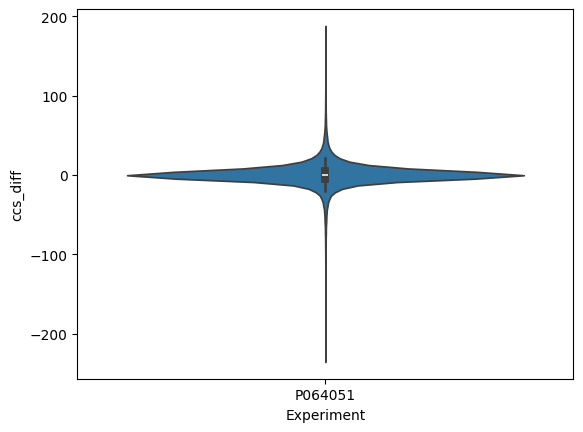

In [37]:
# merging alpha base format back to MaxQuant

df['ccs_pred'] = prediction['ccs_pred']
df['mobility_pred'] = prediction['mobility_pred']
mapping_dict = {
            'sequence': 'Sequence',
            'charge': 'Charge',
            'rt': 'Retention time',
            'ccs': 'CCS',
            'mobility': '1/K0',
            'scan_num': 'MS/MS scan number',
            'raw_name': 'Raw file',
            'precursor_mz': 'm/z',
            'score': 'Score',
            'proteins': 'Proteins',
            'genes': 'Gene names',
            'decoy': 'Reverse',
            'intensity': 'Intensity',
            'nAA':'Length'}
merging_list = ['Sequence', 'Charge', 'CCS', 'Score', 'Length', 'Retention time', 'Proteins', 'Gene names','1/K0' , 'MS/MS scan number', 'Raw file'
                                                  , 'm/z', 'Intensity' ]
        # rename the columns of the alphabase dataframe according to the mapredictionping dict
prediction.rename(columns=mapping_dict, inplace=True)
        # set the original index as index
#prediction.set_index('Original index', inplace=True)
df_merged = pd.merge(df, prediction, on = merging_list, how = 'inner')
#df_merged.to_csv('comparisons/comp__trans_orig.txt', sep = '\t')

df_merged['ccs_diff'] = np.subtract(df_merged['CCS'], df_merged['ccs_pred_y'])
df_merged['IM_diff'] = np.subtract(df_merged['1/K0'], df_merged['mobility_pred_y'])

sns.violinplot(x='Experiment', y='ccs_diff', data=df_merged, density_norm='count')
print(f'Mean Error: {df_merged['ccs_diff'].mean()}')
# percentile of CCS Difference
perc_low = np.percentile(df_merged['ccs_diff'], 2.5)
perc_up = np.percentile(df_merged['ccs_diff'], 97.5)
print(f'Percentiles:({perc_low}, {perc_up})')

print(f'Window:{(perc_low)*(-1)+perc_up}')
window = (perc_low)*(-1)+perc_up


### Run 51 trained model on all experiments

In [18]:
df = pd.read_csv('evidence_freshfrozen_base.txt', sep = '\t')

C:\Users\cocob\AppData\Local\Temp\ipykernel_20332\1075853994.py:1: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('evidence_freshfrozen_base.txt', sep = '\t')


In [8]:
# turn complete df into alpha base format
df = df_base
df.loc[:,'Original index'] = df.index
# run AlphaBase
mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.column_mapping['Original index'] = 'Original index'
mq_reader._translate_columns(df)
mq_reader._transform_table(df)
mq_reader._translate_decoy(df)
mq_reader._translate_score(df)
mq_reader._load_modifications(df)
mq_reader._translate_modifications()
mq_reader._post_process(df)  
df_ab = mq_reader.psm_df

In [9]:
prediction = models.predict_mobility(df_ab)

2024-08-13 13:05:35> Predicting mobility ...


100%|██████████| 46/46 [08:41<00:00, 11.35s/it]


In [10]:
# merging alpha base format back to MaxQuant

df['ccs_pred'] = prediction['ccs_pred']
df['mobility_pred'] = prediction['mobility_pred']
mapping_dict = {
            'sequence': 'Sequence',
            'charge': 'Charge',
            'rt': 'Retention time',
            'ccs': 'CCS',
            'mobility': '1/K0',
            'scan_num': 'MS/MS scan number',
            'raw_name': 'Raw file',
            'precursor_mz': 'm/z',
            'score': 'Score',
            'proteins': 'Proteins',
            'genes': 'Gene names',
            'decoy': 'Reverse',
            'intensity': 'Intensity',
            'nAA':'Length'}
merging_list = ['Sequence', 'Charge', 'CCS', 'Score', 'Length', 'Retention time', 'Proteins', 'Gene names','1/K0' , 'MS/MS scan number', 'Raw file'
                                                  , 'm/z', 'Intensity' ]
        # rename the columns of the alphabase dataframe according to the mapredictionping dict
prediction.rename(columns=mapping_dict, inplace=True)
        # set the original index as index
prediction.set_index('Original index', inplace=True)
df_pred = pd.merge(df, prediction, on = merging_list, how = 'inner')
#df_merged.to_csv('comparisons/comp__trans_orig.txt', sep = '\t')
df_pred['ccs_diff'] = np.subtract(df_pred['CCS'], df_pred['ccs_pred_y'])
df_pred['IM_diff'] = np.subtract(df_pred['1/K0'], df_pred['mobility_pred_y'])


In [13]:
df_pred.to_csv('comparisons/comp_trans_51.txt', sep = '\t')

In [ ]:
# violin plot: experiment vs CCS error
plt.figure(figsize=(10, 6))
sns.violinplot(x='Experiment', y='ccs_diff', data=df_pred, density_norm='count')

# Set plot labels and title
plt.xlabel('Biological Replicate')
plt.ylabel('CCS Error')
plt.hlines(y = 0.0, xmin = -0.5, xmax= 2.5, linestyles='--', colors='grey')

# Display the plot
plt.show()
print(df_pred[df_pred['Experiment']=='P064051']['ccs_diff'].mean())
print(df_pred[df_pred['Experiment']=='P064064']['ccs_diff'].mean())
print(df_pred[df_pred['Experiment']=='P064428']['ccs_diff'].mean())

In [11]:
print(df_pred[df_pred['Experiment']=='P064051']['IM_diff'].mean())
print(df_pred[df_pred['Experiment']=='P064064']['IM_diff'].mean())
print(df_pred[df_pred['Experiment']=='P064428']['IM_diff'].mean())

0.0014698992726788842
-0.022438516893527147
-0.007435647761248255


2024-08-13 18:23:09> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


C:\Users\cocob\AppData\Local\Temp\ipykernel_27244\1249258615.py:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x='Charge', y='ccs_diff', data=df_comp, scale='count')#inner='box',


2024-08-13 18:23:11> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


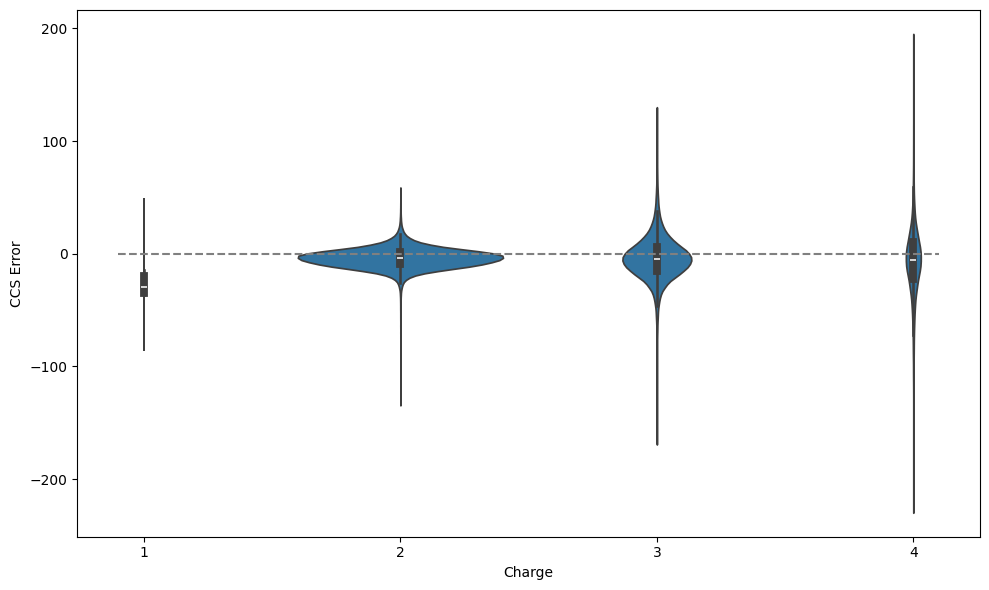

CCS:
-23.856856090082488
22.198228253269647
-3.9358349546488607
8.879124338760757
-3.8420882600932633
19.718909983074713
-7.0950610743108955
31.73853690277886
IM:
-0.11758293927167997
0.10926371868015802
-0.009740281317241134
0.021976653497238957
-0.00635731694343911
0.03263646218552881
-0.008815753094808913
0.039456585204935474


: 

In [14]:
# violin plot: charge vs CCS error
df_comp = df_pred
plt.figure(figsize=(10, 6))
sns.violinplot(x='Charge', y='ccs_diff', data=df_comp, scale='count')#inner='box',

# Set plot labels and title
plt.xlabel('Charge')
plt.ylabel('CCS Error')
plt.hlines(y = 0.0, xmin = -0.1, xmax= 3.1, linestyles='--', colors='grey')
plt.tight_layout()

# Display the plot
plt.show()
print('CCS:')
print(df_comp[df_comp['Charge']==1]['ccs_diff'].mean())
print(df_comp[df_comp['Charge']==1]['ccs_diff'].std())
print(df_comp[df_comp['Charge']==2]['ccs_diff'].mean())
print(df_comp[df_comp['Charge']==2]['ccs_diff'].std())
print(df_comp[df_comp['Charge']==3]['ccs_diff'].mean())
print(df_comp[df_comp['Charge']==3]['ccs_diff'].std())
print(df_comp[df_comp['Charge']==4]['ccs_diff'].mean())
print(df_comp[df_comp['Charge']==4]['ccs_diff'].std())
print('IM:')
print(df_comp[df_comp['Charge']==1]['IM_diff'].mean())
print(df_comp[df_comp['Charge']==1]['IM_diff'].std())
print(df_comp[df_comp['Charge']==2]['IM_diff'].mean())
print(df_comp[df_comp['Charge']==2]['IM_diff'].std())
print(df_comp[df_comp['Charge']==3]['IM_diff'].mean())
print(df_comp[df_comp['Charge']==3]['IM_diff'].std())
print(df_comp[df_comp['Charge']==4]['IM_diff'].mean())
print(df_comp[df_comp['Charge']==4]['IM_diff'].std())

# Ex 64

In [5]:
df = df_64
df_train = df.sample(n = round(0.2*len(df)), random_state=42)
print(len(df_train))

87240


In [6]:
# turn training df into alpha base format
df_train.loc[:,'Original index'] = df_train.index
# run AlphaBase
mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.column_mapping['Original index'] = 'Original index'
mq_reader._translate_columns(df_train)
mq_reader._transform_table(df_train)
mq_reader._translate_decoy(df_train)
mq_reader._translate_score(df_train)
mq_reader._load_modifications(df_train)
mq_reader._translate_modifications()
mq_reader._post_process(df_train)  
df_train_ab = mq_reader.psm_df

In [7]:
models = ModelManager(device = 'gpu')
models.load_installed_models()


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\cuda\__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
models.train_ccs_model(df_train_ab)

2024-08-12 11:56:24> 63785 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [ ]:
# turn complete df into alpha base format
df = df_64
df.loc[:,'Original index'] = df.index
# run AlphaBase
mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.column_mapping['Original index'] = 'Original index'
mq_reader._translate_columns(df)
mq_reader._transform_table(df)
mq_reader._translate_decoy(df)
mq_reader._translate_score(df)
mq_reader._load_modifications(df)
mq_reader._translate_modifications()
mq_reader._post_process(df)  
df_ab = mq_reader.psm_df

C:\Users\cocob\AppData\Local\Temp\ipykernel_20332\1783088516.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


In [ ]:
prediction = models.predict_mobility(df_ab)

2024-07-26 14:27:03> Predicting mobility ...


100%|██████████| 46/46 [02:32<00:00,  3.33s/it]


C:\Users\cocob\AppData\Local\Temp\ipykernel_20332\104791629.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_20332\104791629.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


Mean Error: 0.6336726167993253
Percentiles:(-21.10624040294711, 25.75464071572835)
Window:46.86088111867546


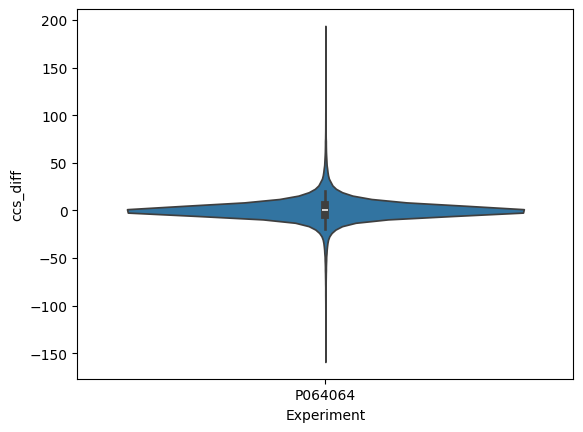

In [ ]:
# merging alpha base format back to MaxQuant

df['ccs_pred'] = prediction['ccs_pred']
df['mobility_pred'] = prediction['mobility_pred']
mapping_dict = {
            'sequence': 'Sequence',
            'charge': 'Charge',
            'rt': 'Retention time',
            'ccs': 'CCS',
            'mobility': '1/K0',
            'scan_num': 'MS/MS scan number',
            'raw_name': 'Raw file',
            'precursor_mz': 'm/z',
            'score': 'Score',
            'proteins': 'Proteins',
            'genes': 'Gene names',
            'decoy': 'Reverse',
            'intensity': 'Intensity',
            'nAA':'Length'}
merging_list = ['Sequence', 'Charge', 'CCS', 'Score', 'Length', 'Retention time', 'Proteins', 'Gene names','1/K0' , 'MS/MS scan number', 'Raw file'
                                                  , 'm/z', 'Intensity' ]
        # rename the columns of the alphabase dataframe according to the mapredictionping dict
prediction.rename(columns=mapping_dict, inplace=True)
        # set the original index as index
prediction.set_index('Original index', inplace=True)
df_merged = pd.merge(df, prediction, on = merging_list, how = 'inner')
#df_merged.to_csv('comparisons/comp__trans_orig.txt', sep = '\t')

df_merged['ccs_diff'] = np.subtract(df_merged['CCS'], df_merged['ccs_pred_y'])
df_merged['IM_diff'] = np.subtract(df_merged['1/K0'], df_merged['mobility_pred_y'])

sns.violinplot(x='Experiment', y='ccs_diff', data=df_merged, density_norm='count')
print(f"Mean Error: {df_merged['ccs_diff'].mean()}")
# percentile of CCS Difference
perc_low = np.percentile(df_merged['ccs_diff'], 2.5)
perc_up = np.percentile(df_merged['ccs_diff'], 97.5)
print(f"Percentiles:({perc_low}, {perc_up})")

print(f"Window:{(perc_low)*(-1)+perc_up}")
window = (perc_low)*(-1)+perc_up


### Run 51 trained model on all experiments

In [23]:
df = pd.read_csv('evidence_freshfrozen_base.txt', sep = '\t')

C:\Users\cocob\AppData\Local\Temp\ipykernel_8080\1075853994.py:1: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('evidence_freshfrozen_base.txt', sep = '\t')


In [9]:
# turn complete df into alpha base format
df = df_base
df.loc[:,'Original index'] = df.index
# run AlphaBase
mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.column_mapping['Original index'] = 'Original index'
mq_reader._translate_columns(df)
mq_reader._transform_table(df)
mq_reader._translate_decoy(df)
mq_reader._translate_score(df)
mq_reader._load_modifications(df)
mq_reader._translate_modifications()
mq_reader._post_process(df)  
df_ab = mq_reader.psm_df

In [10]:
prediction = models.predict_mobility(df_ab)

2024-08-12 12:51:22> Predicting mobility ...


100%|██████████| 46/46 [08:34<00:00, 11.19s/it]


In [12]:
# merging alpha base format back to MaxQuant

df['ccs_pred'] = prediction['ccs_pred']
df['mobility_pred'] = prediction['mobility_pred']
mapping_dict = {
            'sequence': 'Sequence',
            'charge': 'Charge',
            'rt': 'Retention time',
            'ccs': 'CCS',
            'mobility': '1/K0',
            'scan_num': 'MS/MS scan number',
            'raw_name': 'Raw file',
            'precursor_mz': 'm/z',
            'score': 'Score',
            'proteins': 'Proteins',
            'genes': 'Gene names',
            'decoy': 'Reverse',
            'intensity': 'Intensity',
            'nAA':'Length'}
merging_list = ['Sequence', 'Charge', 'CCS', 'Score', 'Length', 'Retention time', 'Proteins', 'Gene names','1/K0' , 'MS/MS scan number', 'Raw file'
                                                  , 'm/z', 'Intensity' ]
        # rename the columns of the alphabase dataframe according to the mapredictionping dict
prediction.rename(columns=mapping_dict, inplace=True)
        # set the original index as index
prediction.set_index('Original index', inplace=True)
df_pred = pd.merge(df, prediction, on = merging_list, how = 'inner')
#df_merged.to_csv('comparisons/comp__trans_orig.txt', sep = '\t')
df_pred['ccs_diff'] = np.subtract(df_pred['CCS'], df_pred['ccs_pred_y'])
df_pred['IM_diff'] = np.subtract(df_pred['1/K0'], df_pred['mobility_pred_y'])


In [ ]:
# violin plot: experiment vs CCS error
plt.figure(figsize=(10, 6))
sns.violinplot(x='Experiment', y='ccs_diff', data=df_pred, density_norm='count')

# Set plot labels and title
plt.xlabel('Biological Replicate')
plt.ylabel('CCS Error')
plt.hlines(y = 0.0, xmin = -0.5, xmax= 2.5, linestyles='--', colors='grey')

# Display the plot
plt.show()
print(df_pred[df_pred['Experiment']=='P064051']['ccs_diff'].mean())
print(df_pred[df_pred['Experiment']=='P064064']['ccs_diff'].mean())
print(df_pred[df_pred['Experiment']=='P064428']['ccs_diff'].mean())

In [13]:
print(df_pred[df_pred['Experiment']=='P064051']['IM_diff'].mean())
print(df_pred[df_pred['Experiment']=='P064064']['IM_diff'].mean())
print(df_pred[df_pred['Experiment']=='P064428']['IM_diff'].mean())

0.024813754052898047
0.001406494252169828
0.015921284222663003


## Ex 28

In [4]:
df = df_28
df_train = df.sample(n = round(0.2*len(df)), random_state=42)
print(len(df_train))

90978


In [5]:
# turn training df into alpha base format
df_train.loc[:,'Original index'] = df_train.index
# run AlphaBase
mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.column_mapping['Original index'] = 'Original index'
mq_reader._translate_columns(df_train)
mq_reader._transform_table(df_train)
mq_reader._translate_decoy(df_train)
mq_reader._translate_score(df_train)
mq_reader._load_modifications(df_train)
mq_reader._translate_modifications()
mq_reader._post_process(df_train)  
df_train_ab = mq_reader.psm_df

In [6]:
models = ModelManager(device = 'gpu')
models.load_installed_models()

c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\cuda\__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [7]:
models.train_ccs_model(df_train_ab)

2024-08-12 13:42:07> 64518 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [9]:
# turn complete df into alpha base format
df = df_28
df.loc[:,'Original index'] = df.index
# run AlphaBase
mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.column_mapping['Original index'] = 'Original index'
mq_reader._translate_columns(df)
mq_reader._transform_table(df)
mq_reader._translate_decoy(df)
mq_reader._translate_score(df)
mq_reader._load_modifications(df)
mq_reader._translate_modifications()
mq_reader._post_process(df)  
df_ab = mq_reader.psm_df

C:\Users\cocob\AppData\Local\Temp\ipykernel_8080\29403090.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


In [10]:
prediction = models.predict_mobility(df_ab)

2024-07-29 12:27:13> Predicting mobility ...


100%|██████████| 46/46 [03:26<00:00,  4.48s/it]


C:\Users\cocob\AppData\Local\Temp\ipykernel_8080\991874481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_8080\991874481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


Mean Error: 0.5812833037114835
Percentiles:(-25.873865320431825, 29.916577467912152)
Window:55.79044278834398


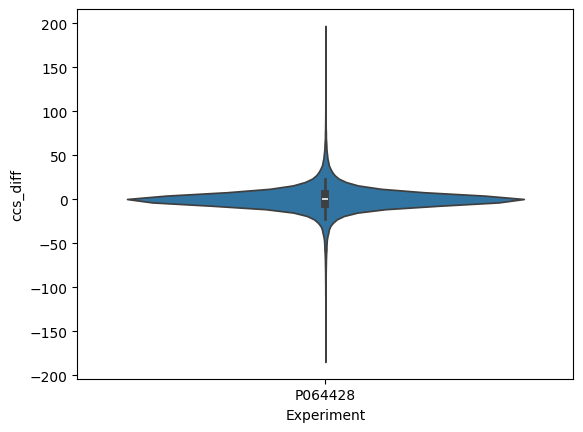

In [14]:
# merging alpha base format back to MaxQuant

df['ccs_pred'] = prediction['ccs_pred']
df['mobility_pred'] = prediction['mobility_pred']
mapping_dict = {
            'sequence': 'Sequence',
            'charge': 'Charge',
            'rt': 'Retention time',
            'ccs': 'CCS',
            'mobility': '1/K0',
            'scan_num': 'MS/MS scan number',
            'raw_name': 'Raw file',
            'precursor_mz': 'm/z',
            'score': 'Score',
            'proteins': 'Proteins',
            'genes': 'Gene names',
            'decoy': 'Reverse',
            'intensity': 'Intensity',
            'nAA':'Length'}
merging_list = ['Sequence', 'Charge', 'CCS', 'Score', 'Length', 'Retention time', 'Proteins', 'Gene names','1/K0' , 'MS/MS scan number', 'Raw file'
                                                  , 'm/z', 'Intensity' ]
        # rename the columns of the alphabase dataframe according to the mapredictionping dict
prediction.rename(columns=mapping_dict, inplace=True)
        # set the original index as index
#prediction.set_index('Original index', inplace=True)
df_merged = pd.merge(df, prediction, on = merging_list, how = 'inner')
#df_merged.to_csv('comparisons/comp__trans_orig.txt', sep = '\t')

df_merged['ccs_diff'] = np.subtract(df_merged['CCS'], df_merged['ccs_pred_y'])
df_merged['IM_diff'] = np.subtract(df_merged['1/K0'], df_merged['mobility_pred_y'])

sns.violinplot(x='Experiment', y='ccs_diff', data=df_merged, density_norm='count')
print(f"Mean Error: {df_merged['ccs_diff'].mean()}")
# percentile of CCS Difference
perc_low = np.percentile(df_merged['ccs_diff'], 2.5)
perc_up = np.percentile(df_merged['ccs_diff'], 97.5)
print(f"Percentiles:({perc_low}, {perc_up})")

print(f"Window:{(perc_low)*(-1)+perc_up}")
window = (perc_low)*(-1)+perc_up


### Run 51 trained model on all experiments

In [15]:
df = pd.read_csv('evidence_freshfrozen_base.txt', sep = '\t')

C:\Users\cocob\AppData\Local\Temp\ipykernel_8080\1075853994.py:1: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('evidence_freshfrozen_base.txt', sep = '\t')


In [8]:
# turn complete df into alpha base format
df = df_base
df.loc[:,'Original index'] = df.index
# run AlphaBase
mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.column_mapping['Original index'] = 'Original index'
mq_reader._translate_columns(df)
mq_reader._transform_table(df)
mq_reader._translate_decoy(df)
mq_reader._translate_score(df)
mq_reader._load_modifications(df)
mq_reader._translate_modifications()
mq_reader._post_process(df)  
df_ab = mq_reader.psm_df

In [9]:
prediction = models.predict_mobility(df_ab)

2024-08-12 14:38:38> Predicting mobility ...


100%|██████████| 46/46 [09:00<00:00, 11.75s/it]


In [10]:
# merging alpha base format back to MaxQuant

df['ccs_pred'] = prediction['ccs_pred']
df['mobility_pred'] = prediction['mobility_pred']
mapping_dict = {
            'sequence': 'Sequence',
            'charge': 'Charge',
            'rt': 'Retention time',
            'ccs': 'CCS',
            'mobility': '1/K0',
            'scan_num': 'MS/MS scan number',
            'raw_name': 'Raw file',
            'precursor_mz': 'm/z',
            'score': 'Score',
            'proteins': 'Proteins',
            'genes': 'Gene names',
            'decoy': 'Reverse',
            'intensity': 'Intensity',
            'nAA':'Length'}
merging_list = ['Sequence', 'Charge', 'CCS', 'Score', 'Length', 'Retention time', 'Proteins', 'Gene names','1/K0' , 'MS/MS scan number', 'Raw file'
                                                  , 'm/z', 'Intensity' ]
        # rename the columns of the alphabase dataframe according to the mapredictionping dict
prediction.rename(columns=mapping_dict, inplace=True)
        # set the original index as index
prediction.set_index('Original index', inplace=True)
df_pred = pd.merge(df, prediction, on = merging_list, how = 'inner')
#df_merged.to_csv('comparisons/comp__trans_orig.txt', sep = '\t')
df_pred['ccs_diff'] = np.subtract(df_pred['CCS'], df_pred['ccs_pred_y'])
df_pred['IM_diff'] = np.subtract(df_pred['1/K0'], df_pred['mobility_pred_y'])


In [ ]:
# violin plot: experiment vs CCS error
plt.figure(figsize=(10, 6))
sns.violinplot(x='Experiment', y='ccs_diff', data=df_pred, density_norm='count')

# Set plot labels and title
plt.xlabel('Biological Replicate')
plt.ylabel('CCS Error')
plt.hlines(y = 0.0, xmin = -0.5, xmax= 2.5, linestyles='--', colors='grey')

# Display the plot
plt.show()
print(df_pred[df_pred['Experiment']=='P064051']['ccs_diff'].mean())
print(df_pred[df_pred['Experiment']=='P064064']['ccs_diff'].mean())
print(df_pred[df_pred['Experiment']=='P064428']['ccs_diff'].mean())

In [11]:
print(df_pred[df_pred['Experiment']=='P064051']['IM_diff'].mean())
print(df_pred[df_pred['Experiment']=='P064064']['IM_diff'].mean())
print(df_pred[df_pred['Experiment']=='P064428']['IM_diff'].mean())

0.0100452667991963
-0.01383899343890935
0.0011003059120152211


# Rawfile wise

In [6]:
def mq_to_ab(df: pd.DataFrame):
    # turn training df into alpha base format
    df.loc[:,'Original index'] = df.index
    # run AlphaBase
    mq_reader = psm_reader_provider.get_reader('maxquant')
    mq_reader.column_mapping['Original index'] = 'Original index'
    mq_reader._translate_columns(df)
    mq_reader._transform_table(df)
    mq_reader._translate_decoy(df)
    mq_reader._translate_score(df)
    mq_reader._load_modifications(df)
    mq_reader._translate_modifications()
    mq_reader._post_process(df)  
    df_ab = mq_reader.psm_df
    return df_ab

In [5]:
def ab_to_mq(df: pd.DataFrame, prediction:pd.DataFrame):
    # merging alpha base format back to MaxQuant
    df['ccs_pred'] = prediction['ccs_pred']
    df['mobility_pred'] = prediction['mobility_pred']
    mapping_dict = {
                'sequence': 'Sequence',
                'charge': 'Charge',
                'rt': 'Retention time',
                'ccs': 'CCS',
                'mobility': '1/K0',
                'scan_num': 'MS/MS scan number',
                'raw_name': 'Raw file',
                'precursor_mz': 'm/z',
                'score': 'Score',
                'proteins': 'Proteins',
                'genes': 'Gene names',
                'decoy': 'Reverse',
                'intensity': 'Intensity',
                'nAA':'Length'}
    merging_list = ['Sequence', 'Charge', 'CCS', 'Score', 'Length', 'Retention time', 'Proteins', 'Gene names','1/K0' , 'MS/MS scan number', 'Raw file'
                                                    , 'm/z', 'Intensity' ]
            # rename the columns of the alphabase dataframe according to the mapredictionping dict
    prediction.rename(columns=mapping_dict, inplace=True)
            # set the original index as index
    prediction.set_index('Original index', inplace=True)
    df_merged = pd.merge(df, prediction, on = merging_list, how = 'inner')
    df_merged['ccs_diff'] = np.subtract(df_merged['CCS'], df_merged['ccs_pred_y'])
    df_merged['IM_diff'] = np.subtract(df_merged['1/K0'], df_merged['mobility_pred_y'])
    return df_merged

In [11]:
# for all experiments
df = df_base
result_dict = {}
# experiments
for experiment in df['Experiment'].unique():
    print(experiment)
    df_ex = df[df['Experiment']== experiment]
    result_dict[experiment] = {}
    # raw file wise
    for raw_file in df_ex['Raw file']:
        print(raw_file)
        df_raw = df_ex[df_ex['Raw file']== raw_file]
        df_ab = mq_to_ab(df_raw)
        df_train = df_ab.sample(n = round(0.2*len(df_ab)))
        models = ModelManager(device = 'gpu')
        models.load_installed_models()      
        models.train_ccs_model(df_train)
        prediction = models.predict_mobility(df_ab)
        df_result = ab_to_mq(df_raw, prediction)
        mean = df_result['ccs_diff'].mean()
        perc_low = np.percentile(df_result['ccs_diff'], 2.5)
        perc_up = np.percentile(df_result['ccs_diff'], 97.5)
        window = (perc_low)*(-1)+perc_up
        result_dict[experiment][raw_file] = [mean, perc_low, perc_up, window]

        


P064051
5471_P064051_R1_U23_GG9_1_2596


C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-02 17:06:13> 2241 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-02 17:09:11> Predicting mobility ...


100%|██████████| 40/40 [00:07<00:00,  5.34it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U24_GH9_1_2597


C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-02 17:09:24> 2131 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-02 17:12:22> Predicting mobility ...


100%|██████████| 40/40 [00:07<00:00,  5.26it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U24_GH9_1_2597


C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-02 17:12:35> 2114 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-02 17:15:26> Predicting mobility ...


100%|██████████| 40/40 [00:05<00:00,  6.76it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U25_GH10_1_2598


C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-02 17:15:36> 2129 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-02 17:18:00> Predicting mobility ...


100%|██████████| 41/41 [00:06<00:00,  6.51it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5471_P064051_R1_U25_GH10_1_2598
2024-08-02 17:18:10> 2136 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-02 17:21:07> Predicting mobility ...


100%|██████████| 41/41 [00:06<00:00,  6.25it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U28_GE10_1_2601


C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-02 17:21:18> 2098 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-02 17:24:17> Predicting mobility ...


100%|██████████| 41/41 [00:06<00:00,  6.42it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U30_GC10_1_2603


C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-02 17:24:28> 2178 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-02 17:27:27> Predicting mobility ...


100%|██████████| 41/41 [00:06<00:00,  6.21it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U31_GB10_1_2604


C:\Users\cocob\AppData\Local\Temp\ipykernel_17172\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-02 17:27:38> 2145 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


KeyboardInterrupt: 

## 51

In [8]:

df_ex = df_51
result_dict_51 = {}
# raw file wise
for raw_file in df_ex['Raw file'].unique():
    print(raw_file)
    df_raw = df_ex[df_ex['Raw file']== raw_file]
    df_ab = mq_to_ab(df_raw)
    df_train = df_ab.sample(n = round(0.3*len(df_ab)))
    print(len(df_train))
    print(len(df_raw))
    models = ModelManager(device = 'gpu')
    models.load_installed_models()      
    models.train_ccs_model(df_train)
    prediction = models.predict_mobility(df_ab)
    df_result = ab_to_mq(df_raw, prediction)
    mean = df_result['ccs_diff'].mean()
    perc_low = np.percentile(df_result['ccs_diff'], 2.5)
    perc_up = np.percentile(df_result['ccs_diff'], 97.5)
    window = (perc_low)*(-1)+perc_up
    result_dict_51[raw_file] = [mean, perc_low, perc_up, window]       


5471_P064051_R1_U23_GG9_1_2596


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


3490
11634
2024-08-16 20:36:28> 3331 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 20:42:05> Predicting mobility ...


100%|██████████| 40/40 [00:10<00:00,  3.93it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U24_GH9_1_2597


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


3308
11028
2024-08-16 20:42:23> 3103 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 20:45:29> Predicting mobility ...


100%|██████████| 40/40 [00:05<00:00,  7.98it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U25_GH10_1_2598


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


3335
11117
2024-08-16 20:45:37> 3143 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 20:48:39> Predicting mobility ...


100%|██████████| 41/41 [00:04<00:00,  8.64it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5471_P064051_R1_U28_GE10_1_2601
3240
10800
2024-08-16 20:48:46> 3105 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 20:51:48> Predicting mobility ...


100%|██████████| 41/41 [00:04<00:00,  8.93it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5471_P064051_R1_U30_GC10_1_2603
3386
11288
2024-08-16 20:51:55> 3210 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 20:54:56> Predicting mobility ...


100%|██████████| 41/41 [00:04<00:00,  8.65it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5471_P064051_R1_U31_GB10_1_2604
3319
11063
2024-08-16 20:55:04> 3176 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 20:58:08> Predicting mobility ...


100%|██████████| 41/41 [00:04<00:00,  8.23it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5471_P064051_R1_U33_GA11_1_2606
2988
9959
2024-08-16 20:58:16> 2870 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 21:01:04> Predicting mobility ...


100%|██████████| 39/39 [00:04<00:00,  8.55it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5471_P064051_R1_U22_GF9_1_2595
3519
11730
2024-08-16 21:01:11> 3354 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 21:04:24> Predicting mobility ...


100%|██████████| 39/39 [00:04<00:00,  7.81it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5471_P064051_R1_U44_GE12_1_2617
3151
10502
2024-08-16 21:04:32> 3002 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 21:07:25> Predicting mobility ...


100%|██████████| 41/41 [00:04<00:00,  8.81it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5471_P064051_R1_U45_GD12_1_2618
3252
10839
2024-08-16 21:07:32> 3087 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 21:10:31> Predicting mobility ...


100%|██████████| 39/39 [00:04<00:00,  8.22it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5471_P064051_R1_U36_GD11_1_2609
3513
11711
2024-08-16 21:10:39> 3327 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 21:13:51> Predicting mobility ...


100%|██████████| 41/41 [00:04<00:00,  8.41it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5471_P064051_R1_U37_GE11_1_2610
3203
10677
2024-08-16 21:13:59> 3068 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 21:17:00> Predicting mobility ...


100%|██████████| 41/41 [00:04<00:00,  8.59it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5471_P064051_R1_U38_GF11_1_2611
3195
10649
2024-08-16 21:17:08> 3023 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 21:20:04> Predicting mobility ...


100%|██████████| 43/43 [00:04<00:00,  9.36it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5471_P064051_R1_U40_GH11_1_2613
3288
10961
2024-08-16 21:20:12> 3130 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 21:23:15> Predicting mobility ...


100%|██████████| 41/41 [00:04<00:00,  8.34it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5471_P064051_R1_U8_GH7_1_2581
2803
9344
2024-08-16 21:23:23> 2688 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 21:26:42> Predicting mobility ...


100%|██████████| 38/38 [00:07<00:00,  5.11it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U2_GB7_1_2575


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2282
7606
2024-08-16 21:27:00> 2156 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 21:29:48> Predicting mobility ...


100%|██████████| 39/39 [00:08<00:00,  4.84it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U3_GC7_1_2576


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2599
8662
2024-08-16 21:30:05> 2488 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 21:33:49> Predicting mobility ...


100%|██████████| 39/39 [00:06<00:00,  6.42it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U5_GE7_1_2578


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2599
8664
2024-08-16 21:34:01> 2462 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 21:36:47> Predicting mobility ...


100%|██████████| 38/38 [00:04<00:00,  8.63it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U41_GH12_1_2614


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


3410
11365
2024-08-16 21:36:55> 3260 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 21:40:47> Predicting mobility ...


100%|██████████| 42/42 [00:11<00:00,  3.61it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U42_GG12_1_2615


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


3322
11075
2024-08-16 21:41:07> 3167 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 21:44:30> Predicting mobility ...


100%|██████████| 40/40 [00:06<00:00,  6.07it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U43_GF12_1_2616


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2932
9772
2024-08-16 21:44:41> 2808 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 21:47:56> Predicting mobility ...


100%|██████████| 40/40 [00:05<00:00,  7.18it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U46_GC12_1_2619


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


4142
13805
2024-08-16 21:48:05> 3927 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 21:53:00> Predicting mobility ...


100%|██████████| 40/40 [00:10<00:00,  3.75it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U47_GB12_1_2620


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


4797
15989
2024-08-16 21:53:23> 4495 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 21:58:14> Predicting mobility ...


100%|██████████| 39/39 [00:08<00:00,  4.67it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U48_GA12_1_2621


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


3793
12643
2024-08-16 21:58:30> 3645 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 22:02:42> Predicting mobility ...


100%|██████████| 39/39 [00:07<00:00,  5.06it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U1_GA7_1_2574


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2920
9735
2024-08-16 22:02:56> 2756 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 22:06:14> Predicting mobility ...


100%|██████████| 39/39 [00:06<00:00,  6.43it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U39_GG11_1_2612


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


3296
10988
2024-08-16 22:06:30> 3136 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 22:09:36> Predicting mobility ...


100%|██████████| 43/43 [00:05<00:00,  8.00it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U34_GB11_1_2607


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


3299
10997
2024-08-16 22:09:47> 3148 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 22:12:46> Predicting mobility ...


100%|██████████| 38/38 [00:04<00:00,  7.83it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5471_P064051_R1_U17_GA9_1_2590
3247
10823
2024-08-16 22:12:54> 3102 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 22:15:52> Predicting mobility ...


100%|██████████| 40/40 [00:04<00:00,  8.55it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5471_P064051_R1_U18_GB9_1_2591
2993
9977
2024-08-16 22:16:00> 2870 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 22:18:43> Predicting mobility ...


100%|██████████| 40/40 [00:04<00:00,  9.49it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5471_P064051_R1_U27_GF10_1_2600
3359
11198
2024-08-16 22:18:50> 3208 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 22:21:51> Predicting mobility ...


100%|██████████| 40/40 [00:04<00:00,  8.35it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5471_P064051_R1_U35_GC11_1_2608
3120
10401
2024-08-16 22:21:59> 2991 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 22:24:45> Predicting mobility ...


100%|██████████| 40/40 [00:04<00:00,  8.87it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5471_P064051_R1_U19_GC9_1_2592
3244
10813
2024-08-16 22:24:53> 3095 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 22:27:52> Predicting mobility ...


100%|██████████| 41/41 [00:05<00:00,  7.61it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5471_P064051_R1_U20_GD9_1_2593
3164
10546
2024-08-16 22:28:01> 3025 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 22:30:53> Predicting mobility ...


100%|██████████| 37/37 [00:04<00:00,  8.05it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5471_P064051_R1_U21_GE9_1_2594
3213
10709
2024-08-16 22:31:01> 3072 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 22:34:05> Predicting mobility ...


100%|██████████| 39/39 [00:05<00:00,  6.83it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U4_GD7_1_2577


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2271
7569
2024-08-16 22:34:17> 2180 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 22:41:28> Predicting mobility ...


100%|██████████| 39/39 [00:10<00:00,  3.55it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U15_GB8_1_2588


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


3230
10768
2024-08-16 22:41:58> 3115 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 22:47:45> Predicting mobility ...


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U16_GA8_1_2589


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


3062
10206
2024-08-16 22:48:07> 2926 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 22:53:32> Predicting mobility ...


100%|██████████| 39/39 [00:11<00:00,  3.41it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U13_GD8_1_2586


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2698
8994
2024-08-16 22:53:55> 2584 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 22:58:37> Predicting mobility ...


100%|██████████| 38/38 [00:10<00:00,  3.68it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U14_GC8_1_2587


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


3199
10662
2024-08-16 22:59:02> 3071 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-16 23:04:41> Predicting mobility ...


100%|██████████| 40/40 [00:12<00:00,  3.30it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U32_GA10_1_2605


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


3409
11364
2024-08-16 23:05:07> 3262 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-17 09:41:31> Predicting mobility ...


100%|██████████| 40/40 [00:18<00:00,  2.16it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U29_GD10_1_2602


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


3374
11246
2024-08-17 09:42:05> 3219 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-17 09:46:44> Predicting mobility ...


100%|██████████| 40/40 [00:08<00:00,  4.73it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U9_GH8_1_2582


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


3048
10161
2024-08-17 09:47:04> 2915 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-17 09:50:10> Predicting mobility ...


100%|██████████| 39/39 [00:09<00:00,  4.11it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U6_GF7_1_2579


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2547
8489
2024-08-17 09:50:32> 2444 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-17 09:53:37> Predicting mobility ...


100%|██████████| 40/40 [00:04<00:00,  9.53it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U7_GG7_1_2580


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2390
7965
2024-08-17 09:53:55> 2288 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-17 09:57:03> Predicting mobility ...


100%|██████████| 39/39 [00:08<00:00,  4.60it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U10_GG8_1_2583


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2714
9048
2024-08-17 09:57:25> 2586 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-17 10:02:04> Predicting mobility ...


100%|██████████| 40/40 [00:10<00:00,  3.82it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U11_GF8_1_2584


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2887
9623
2024-08-17 10:02:29> 2759 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-17 10:07:46> Predicting mobility ...


100%|██████████| 38/38 [00:14<00:00,  2.57it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U12_GE8_1_2585


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2660
8865
2024-08-17 10:08:15> 2537 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-17 10:12:59> Predicting mobility ...


100%|██████████| 38/38 [00:11<00:00,  3.37it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5471_P064051_R1_U26_GG10_1_2599


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


3435
11450
2024-08-17 10:13:26> 3274 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-17 10:19:14> Predicting mobility ...


100%|██████████| 40/40 [00:11<00:00,  3.61it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


In [9]:
import pickle
with open('TL_rawfile_51_30.pkl', 'wb') as f:
    pickle.dump(result_dict_51, f)

In [15]:
with open('TL_rawfile_51.pkl', 'rb') as f:
    result_dict_51 = pickle.load(f)

## 64

In [4]:

df_ex = df_64
result_dict_64 = {}
# raw file wise
for raw_file in df_ex['Raw file'].unique():
    print(raw_file)
    df_raw = df_ex[df_ex['Raw file']== raw_file]
    df_ab = mq_to_ab(df_raw)
    df_train = df_ab.sample(n = round(0.2*len(df_ab)))
    models = ModelManager(device = 'gpu')
    models.load_installed_models()      
    models.train_ccs_model(df_train)
    prediction = models.predict_mobility(df_ab)
    df_result = ab_to_mq(df_raw, prediction)
    mean = df_result['ccs_diff'].mean()
    perc_low = np.percentile(df_result['ccs_diff'], 2.5)
    perc_up = np.percentile(df_result['ccs_diff'], 97.5)
    window = (perc_low)*(-1)+perc_up
    result_dict_64[raw_file] = [mean, perc_low, perc_up, window]       


5478_P064064_R1_U22_BF3_1_3283


NameError: name 'mq_to_ab' is not defined

In [10]:
import pickle
with open('TL_rawfile_64.pkl', 'wb') as f:
    pickle.dump(result_dict_64, f)

In [ ]:
with open('TL_rawfile_64.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

## 28

In [11]:

df_ex = df_28
result_dict_28 = {}
# raw file wise
for raw_file in df_ex['Raw file'].unique():
    print(raw_file)
    df_raw = df_ex[df_ex['Raw file']== raw_file]
    df_ab = mq_to_ab(df_raw)
    df_train = df_ab.sample(n = round(0.2*len(df_ab)))
    models = ModelManager(device = 'gpu')
    models.load_installed_models()      
    models.train_ccs_model(df_train)
    prediction = models.predict_mobility(df_ab)
    df_result = ab_to_mq(df_raw, prediction)
    mean = df_result['ccs_diff'].mean()
    perc_low = np.percentile(df_result['ccs_diff'], 2.5)
    perc_up = np.percentile(df_result['ccs_diff'], 97.5)
    window = (perc_low)*(-1)+perc_up
    result_dict_28[raw_file] = [mean, perc_low, perc_up, window]       


5546_P064428_R1_U22_BF9_1_4672


C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-03 12:39:25> 1767 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 12:42:03> Predicting mobility ...


100%|██████████| 38/38 [00:06<00:00,  5.82it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5546_P064428_R1_U23_BG9_1_4673


C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-03 12:42:16> 1844 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 12:44:57> Predicting mobility ...


100%|██████████| 39/39 [00:08<00:00,  4.85it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5546_P064428_R1_U24_BH9_1_4674


C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-03 12:45:11> 1842 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 12:47:52> Predicting mobility ...


100%|██████████| 39/39 [00:06<00:00,  6.43it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U25_BH10_1_4675
2024-08-03 12:48:05> 1861 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 12:50:43> Predicting mobility ...


100%|██████████| 38/38 [00:07<00:00,  5.36it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U26_BG10_1_4676
2024-08-03 12:50:56> 1775 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 12:53:29> Predicting mobility ...


100%|██████████| 40/40 [00:05<00:00,  6.99it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U27_BF10_1_4677
2024-08-03 12:53:40> 1998 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 12:56:29> Predicting mobility ...


100%|██████████| 39/39 [00:07<00:00,  5.51it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U28_BE10_1_4678
2024-08-03 12:56:42> 1790 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 12:59:17> Predicting mobility ...


100%|██████████| 38/38 [00:05<00:00,  6.97it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U29_BD10_1_4679
2024-08-03 12:59:28> 1820 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 13:02:09> Predicting mobility ...


100%|██████████| 40/40 [00:05<00:00,  6.97it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5546_P064428_R1_U30_BC10_1_4680


C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-03 13:02:20> 2018 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 13:05:11> Predicting mobility ...


100%|██████████| 38/38 [00:06<00:00,  5.72it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U31_BB10_1_4681
2024-08-03 13:05:23> 1784 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 13:08:01> Predicting mobility ...


100%|██████████| 40/40 [00:06<00:00,  6.32it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U32_BA10_1_4682
2024-08-03 13:08:13> 1792 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 13:10:52> Predicting mobility ...


100%|██████████| 38/38 [00:06<00:00,  5.84it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U34_BB11_1_4684
2024-08-03 13:11:04> 1904 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 13:13:56> Predicting mobility ...


100%|██████████| 40/40 [00:07<00:00,  5.15it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5546_P064428_R1_U35_BC11_1_4685


C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-03 13:14:10> 1807 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 13:16:51> Predicting mobility ...


100%|██████████| 41/41 [00:06<00:00,  6.38it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U36_BD11_1_4686
2024-08-03 13:17:03> 1898 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 13:19:57> Predicting mobility ...


100%|██████████| 40/40 [00:06<00:00,  5.94it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5546_P064428_R1_U37_BE11_1_4687


C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-03 13:20:09> 1753 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 14:37:24> Predicting mobility ...


100%|██████████| 40/40 [00:08<00:00,  4.88it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5546_P064428_R1_U38_BF11_1_4688


C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-03 14:37:43> 1811 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 14:41:38> Predicting mobility ...


100%|██████████| 40/40 [00:11<00:00,  3.46it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5546_P064428_R1_U39_BG11_1_4689


C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-03 14:42:02> 1689 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 14:45:17> Predicting mobility ...


100%|██████████| 37/37 [00:07<00:00,  4.93it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5546_P064428_R1_U40_BH11_1_4690


C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-03 14:45:31> 1742 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 14:48:14> Predicting mobility ...


100%|██████████| 41/41 [00:06<00:00,  6.12it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5546_P064428_R1_U41_BH12_1_4691


C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-03 14:48:27> 1883 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 14:51:12> Predicting mobility ...


100%|██████████| 39/39 [00:07<00:00,  5.16it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5546_P064428_R1_U43_BF12_1_4693


C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-03 14:51:26> 1998 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 14:54:06> Predicting mobility ...


100%|██████████| 38/38 [00:07<00:00,  4.99it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U44_BE12_1_4694
2024-08-03 14:54:20> 1733 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 14:56:47> Predicting mobility ...


100%|██████████| 38/38 [00:06<00:00,  5.62it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5546_P064428_R1_U46_BC12_1_4696


C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-03 14:57:00> 2391 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:00:24> Predicting mobility ...


100%|██████████| 37/37 [00:09<00:00,  4.08it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5546_P064428_R1_U47_BB12_1_4697


C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-03 15:00:40> 2552 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:04:17> Predicting mobility ...


100%|██████████| 41/41 [00:09<00:00,  4.23it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5546_P064428_R1_U48_BA12_1_4698


C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-03 15:04:32> 2595 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:07:51> Predicting mobility ...


100%|██████████| 39/39 [00:09<00:00,  4.20it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5546_P064428_R1_U8_BH7_1_4658


C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-03 15:08:06> 1877 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:10:39> Predicting mobility ...


100%|██████████| 39/39 [00:05<00:00,  6.54it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


5546_P064428_R1_U1_BA7_1_4651


C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-03 15:10:51> 1526 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:13:01> Predicting mobility ...


100%|██████████| 38/38 [00:05<00:00,  7.20it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U33_BA11_1_4683
2024-08-03 15:13:12> 1926 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:15:52> Predicting mobility ...


100%|██████████| 40/40 [00:06<00:00,  5.96it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U16_BA8_1_4666
2024-08-03 15:16:05> 1784 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:18:38> Predicting mobility ...


100%|██████████| 39/39 [00:05<00:00,  6.79it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U17_BA9_1_4667
2024-08-03 15:18:50> 1768 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:21:08> Predicting mobility ...


100%|██████████| 40/40 [00:03<00:00, 12.18it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U18_BB9_1_4668
2024-08-03 15:21:14> 1882 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:23:10> Predicting mobility ...


100%|██████████| 40/40 [00:04<00:00,  9.68it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U19_BC9_1_4669
2024-08-03 15:23:17> 1807 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:25:07> Predicting mobility ...


100%|██████████| 38/38 [00:03<00:00, 10.41it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U20_BD9_1_4670
2024-08-03 15:25:14> 1878 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:27:09> Predicting mobility ...


100%|██████████| 38/38 [00:03<00:00,  9.75it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U42_BG12_1_4692
2024-08-03 15:27:15> 1749 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:29:00> Predicting mobility ...


100%|██████████| 36/36 [00:03<00:00,  9.95it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U2_BB7_1_4652
2024-08-03 15:29:07> 1519 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:30:41> Predicting mobility ...


100%|██████████| 37/37 [00:03<00:00, 11.87it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U4_BD7_1_4654
2024-08-03 15:30:47> 1607 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:32:26> Predicting mobility ...


100%|██████████| 38/38 [00:03<00:00, 11.73it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U21_BE9_1_4671
2024-08-03 15:32:32> 1848 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:34:28> Predicting mobility ...


100%|██████████| 39/39 [00:04<00:00,  7.87it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U14_BC8_1_4664
2024-08-03 15:34:37> 1754 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:36:39> Predicting mobility ...


100%|██████████| 38/38 [00:04<00:00,  8.41it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U15_BB8_1_4665
2024-08-03 15:36:47> 1859 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:38:44> Predicting mobility ...


100%|██████████| 39/39 [00:04<00:00,  9.70it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U6_BF7_1_4656
2024-08-03 15:38:51> 1519 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:40:27> Predicting mobility ...


100%|██████████| 36/36 [00:03<00:00, 11.49it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U12_BE8_1_4662
2024-08-03 15:40:32> 1756 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:42:25> Predicting mobility ...


100%|██████████| 37/37 [00:03<00:00,  9.60it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U13_BD8_1_4663
2024-08-03 15:42:32> 1784 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:44:21> Predicting mobility ...


100%|██████████| 36/36 [00:03<00:00,  9.18it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U5_BE7_1_4655
2024-08-03 15:44:28> 1606 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:46:07> Predicting mobility ...


100%|██████████| 36/36 [00:03<00:00,  9.10it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U9_BH8_1_4659
2024-08-03 15:46:13> 1822 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:48:05> Predicting mobility ...


100%|██████████| 38/38 [00:03<00:00, 10.01it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U10_BG8_1_4660
2024-08-03 15:48:12> 1785 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:50:02> Predicting mobility ...


100%|██████████| 37/37 [00:03<00:00,  9.49it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U45_BD12_1_4695
2024-08-03 15:50:09> 1793 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:52:00> Predicting mobility ...


100%|██████████| 38/38 [00:03<00:00, 10.47it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U7_BG7_1_4657
2024-08-03 15:52:06> 1812 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:53:56> Predicting mobility ...


100%|██████████| 36/36 [00:03<00:00,  9.79it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U3_BC7_1_4653
2024-08-03 15:54:03> 1470 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:55:33> Predicting mobility ...


100%|██████████| 35/35 [00:03<00:00, 11.21it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

5546_P064428_R1_U11_BF8_1_4661
2024-08-03 15:55:38> 1793 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-03 15:57:32> Predicting mobility ...


100%|██████████| 37/37 [00:03<00:00,  9.40it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28684\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


In [13]:
import pickle
with open('TL_rawfile_28.pkl', 'wb') as f:
    pickle.dump(result_dict_28, f)

In [ ]:
with open('TL_rawfile_28.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

## Try different training sizes

In [20]:
print(len(df_51['Raw file'].unique()))
print(df_51['Raw file'].unique())

48
['5471_P064051_R1_U23_GG9_1_2596' '5471_P064051_R1_U24_GH9_1_2597'
 '5471_P064051_R1_U25_GH10_1_2598' '5471_P064051_R1_U28_GE10_1_2601'
 '5471_P064051_R1_U30_GC10_1_2603' '5471_P064051_R1_U31_GB10_1_2604'
 '5471_P064051_R1_U33_GA11_1_2606' '5471_P064051_R1_U22_GF9_1_2595'
 '5471_P064051_R1_U44_GE12_1_2617' '5471_P064051_R1_U45_GD12_1_2618'
 '5471_P064051_R1_U36_GD11_1_2609' '5471_P064051_R1_U37_GE11_1_2610'
 '5471_P064051_R1_U38_GF11_1_2611' '5471_P064051_R1_U40_GH11_1_2613'
 '5471_P064051_R1_U8_GH7_1_2581' '5471_P064051_R1_U2_GB7_1_2575'
 '5471_P064051_R1_U3_GC7_1_2576' '5471_P064051_R1_U5_GE7_1_2578'
 '5471_P064051_R1_U41_GH12_1_2614' '5471_P064051_R1_U42_GG12_1_2615'
 '5471_P064051_R1_U43_GF12_1_2616' '5471_P064051_R1_U46_GC12_1_2619'
 '5471_P064051_R1_U47_GB12_1_2620' '5471_P064051_R1_U48_GA12_1_2621'
 '5471_P064051_R1_U1_GA7_1_2574' '5471_P064051_R1_U39_GG11_1_2612'
 '5471_P064051_R1_U34_GB11_1_2607' '5471_P064051_R1_U17_GA9_1_2590'
 '5471_P064051_R1_U18_GB9_1_2591' '5471_P0640

In [30]:
rawfile_sample = ['5471_P064051_R1_U23_GG9_1_2596', '5471_P064051_R1_U28_GE10_1_2601', '5471_P064051_R1_U33_GA11_1_2606', '5471_P064051_R1_U45_GD12_1_2618', '5471_P064051_R1_U38_GF11_1_2611',
                 '5471_P064051_R1_U2_GB7_1_2575', '5471_P064051_R1_U41_GH12_1_2614',  '5471_P064051_R1_U46_GC12_1_2619', '5471_P064051_R1_U1_GA7_1_2574', '5471_P064051_R1_U13_GD8_1_2586']
train_size = [0.6,0.7,0.8]

In [24]:
df_try = df_51[df_51['Raw file'].isin(rawfile_sample)]

In [25]:
print(df_try.shape)
print(len(df_try['Raw file'].unique()))

(105386, 71)
10


In [31]:

df_ex = df_try
for size in train_size:
    print(size)
    result_dict = {}
    # raw file wise
    for raw_file in df_ex['Raw file'].unique():
        df_raw = df_ex[df_ex['Raw file']== raw_file]
        df_ab = mq_to_ab(df_raw)
        df_train = df_ab.sample(n = round(size*len(df_ab)))
        models = ModelManager(device = 'gpu')
        models.load_installed_models()      
        models.train_ccs_model(df_train)
        prediction = models.predict_mobility(df_ab)
        df_result = ab_to_mq(df_raw, prediction)
        mean = df_result['ccs_diff'].mean()
        perc_low = np.percentile(df_result['ccs_diff'], 2.5)
        perc_up = np.percentile(df_result['ccs_diff'], 97.5)
        window = (perc_low)*(-1)+perc_up
        result_dict[raw_file] = [mean, perc_low, perc_up, window]  
    with open(f'train_size_test/51_{size*100}.pkl', 'wb') as f:
        pickle.dump(result_dict, f)
             


0.6


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-18 10:00:53> 6370 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 10:06:39> Predicting mobility ...


100%|██████████| 40/40 [00:06<00:00,  5.73it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 10:06:51> 5997 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 10:12:11> Predicting mobility ...


100%|██████████| 41/41 [00:05<00:00,  7.55it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 10:12:19> 5543 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 10:17:42> Predicting mobility ...


100%|██████████| 39/39 [00:05<00:00,  7.77it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 10:17:50> 5936 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 10:23:16> Predicting mobility ...


100%|██████████| 39/39 [00:05<00:00,  7.41it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 10:23:25> 5816 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 10:28:53> Predicting mobility ...


100%|██████████| 43/43 [00:05<00:00,  8.39it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 10:29:01> 4169 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 10:32:49> Predicting mobility ...


100%|██████████| 39/39 [00:03<00:00, 11.14it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 10:32:55> 6224 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 10:38:27> Predicting mobility ...


100%|██████████| 42/42 [00:04<00:00,  8.50it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 10:38:35> 7542 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 10:44:51> Predicting mobility ...


100%|██████████| 40/40 [00:06<00:00,  6.62it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 10:45:00> 5238 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 10:49:03> Predicting mobility ...


100%|██████████| 39/39 [00:04<00:00,  8.78it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 10:49:10> 4985 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 10:53:09> Predicting mobility ...


100%|██████████| 38/38 [00:04<00:00,  8.76it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


0.7


C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Original index'] = df.index


2024-08-18 10:53:17> 7353 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 10:59:03> Predicting mobility ...


100%|██████████| 40/40 [00:05<00:00,  7.74it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 10:59:12> 6906 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 11:04:34> Predicting mobility ...


100%|██████████| 41/41 [00:04<00:00,  8.35it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 11:04:44> 6404 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 11:09:41> Predicting mobility ...


100%|██████████| 39/39 [00:04<00:00,  8.65it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 11:09:49> 6838 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 11:15:07> Predicting mobility ...


100%|██████████| 39/39 [00:05<00:00,  7.33it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 11:15:16> 6718 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 11:20:28> Predicting mobility ...


100%|██████████| 43/43 [00:04<00:00,  8.90it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 11:20:36> 4805 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 11:24:26> Predicting mobility ...


100%|██████████| 39/39 [00:03<00:00, 11.47it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 11:24:33> 7222 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 11:30:14> Predicting mobility ...


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 11:30:25> 8713 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 11:37:15> Predicting mobility ...


100%|██████████| 40/40 [00:06<00:00,  6.53it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 11:37:24> 6010 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 11:42:00> Predicting mobility ...


100%|██████████| 39/39 [00:04<00:00,  9.59it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 11:42:07> 5779 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 11:46:35> Predicting mobility ...


100%|██████████| 38/38 [00:03<00:00,  9.51it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

0.8
2024-08-18 11:46:43> 8307 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 11:52:58> Predicting mobility ...


100%|██████████| 40/40 [00:05<00:00,  7.39it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 11:53:07> 7841 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 12:00:00> Predicting mobility ...


100%|██████████| 41/41 [00:06<00:00,  5.86it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 12:00:13> 7216 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 14:01:53> Predicting mobility ...


100%|██████████| 39/39 [00:12<00:00,  3.07it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 14:02:17> 7713 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 14:13:56> Predicting mobility ...


100%|██████████| 39/39 [00:13<00:00,  2.98it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 14:14:23> 7604 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 14:25:18> Predicting mobility ...


100%|██████████| 43/43 [00:12<00:00,  3.46it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 14:25:41> 5434 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 14:34:20> Predicting mobility ...


100%|██████████| 39/39 [00:09<00:00,  3.92it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 14:34:41> 8150 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 14:48:59> Predicting mobility ...


100%|██████████| 42/42 [00:12<00:00,  3.41it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 14:49:24> 9859 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 15:02:21> Predicting mobility ...


100%|██████████| 40/40 [00:11<00:00,  3.36it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 15:02:41> 6799 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 15:13:13> Predicting mobility ...


100%|██████████| 39/39 [00:11<00:00,  3.51it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3962292996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

2024-08-18 15:13:36> 6523 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2024-08-18 15:24:54> Predicting mobility ...


100%|██████████| 38/38 [00:11<00:00,  3.43it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ccs_pred'] = prediction['ccs_pred']
C:\Users\cocob\AppData\Local\Temp\ipykernel_28576\3783268434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mobility_pred'] = prediction['mobility_pred']


In [ ]:
import pickle
with open('TL_rawfile_51_30.pkl', 'wb') as f:
    pickle.dump(result_dict_51, f)

## Plots

In [1]:
import pickle
with open('TL_rawfile_51.pkl', 'rb') as f:
    result_dict_51 = pickle.load(f)


In [2]:
with open('TL_rawfile_64.pkl', 'rb') as f:
    result_dict_64 = pickle.load(f)

with open('TL_rawfile_28.pkl', 'rb') as f:
    result_dict_28 = pickle.load(f)

In [13]:
result_dict_51_30 = result_dict_51

In [15]:
result_51 = pd.DataFrame.from_dict(result_dict_51)
result_51 = result_51.T
result_51.columns = ['Mean', 'Lower bound', 'Upper bound', 'Window']

In [16]:
result_51_30 = pd.DataFrame.from_dict(result_dict_51_30)
result_51_30 = result_51_30.T
result_51_30.columns = ['Mean', 'Lower bound', 'Upper bound', 'Window']

In [5]:
result_64 = pd.DataFrame.from_dict(result_dict_64)
result_64 = result_64.T
result_64.columns = ['Mean', 'Lower bound', 'Upper bound', 'Window']

In [6]:
result_28 = pd.DataFrame.from_dict(result_dict_28)
result_28 = result_28.T
result_28.columns = ['Mean', 'Lower bound', 'Upper bound', 'Window']

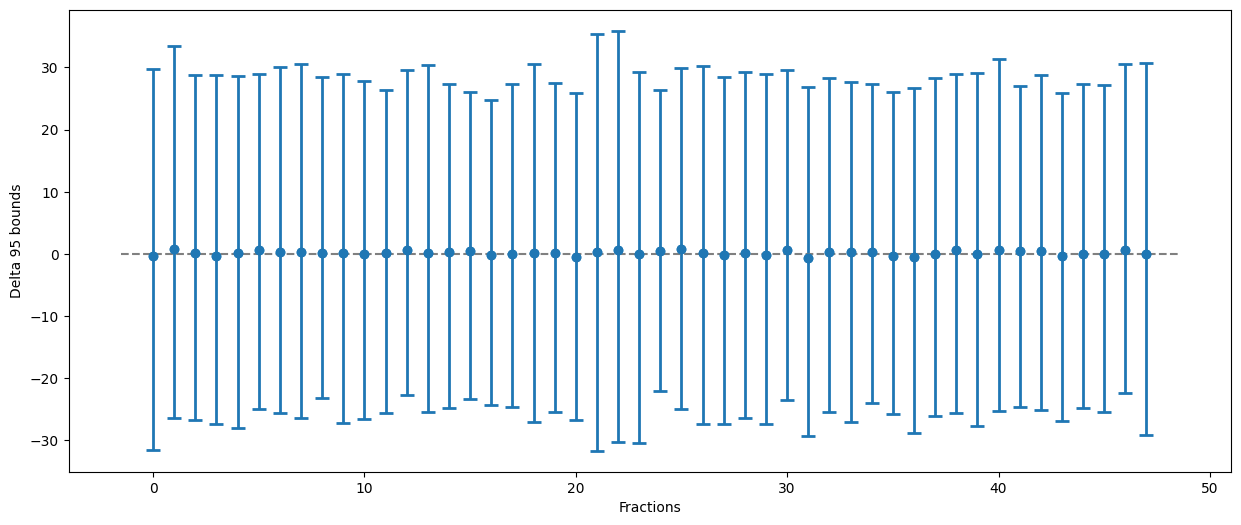

In [13]:
df = result_51
df['error_lower'] = df['Mean'] - df['Lower bound']
df['error_upper'] = df['Upper bound'] - df['Mean']

# Plot setup
plt.figure(figsize=(15, 6))

# Plotting the error bars
plt.errorbar(x=range(len(df)), y=df['Mean'], 
             yerr=[df['error_lower'], df['error_upper']], 
             fmt='o', capsize=5, capthick=2,   elinewidth=2)#ecolor='gray',color='blue',
plt.scatter(x= range(len(df)), y=df['Mean'],  label='CCS prediction', zorder=5)
# Customize the plot
plt.xlabel('Fractions')
plt.ylabel('Delta 95 bounds')
plt.grid(False)
plt.hlines(y = 0.0, xmin = -1.5, xmax= 48.5, linestyles='--', colors='grey')
plt.show()

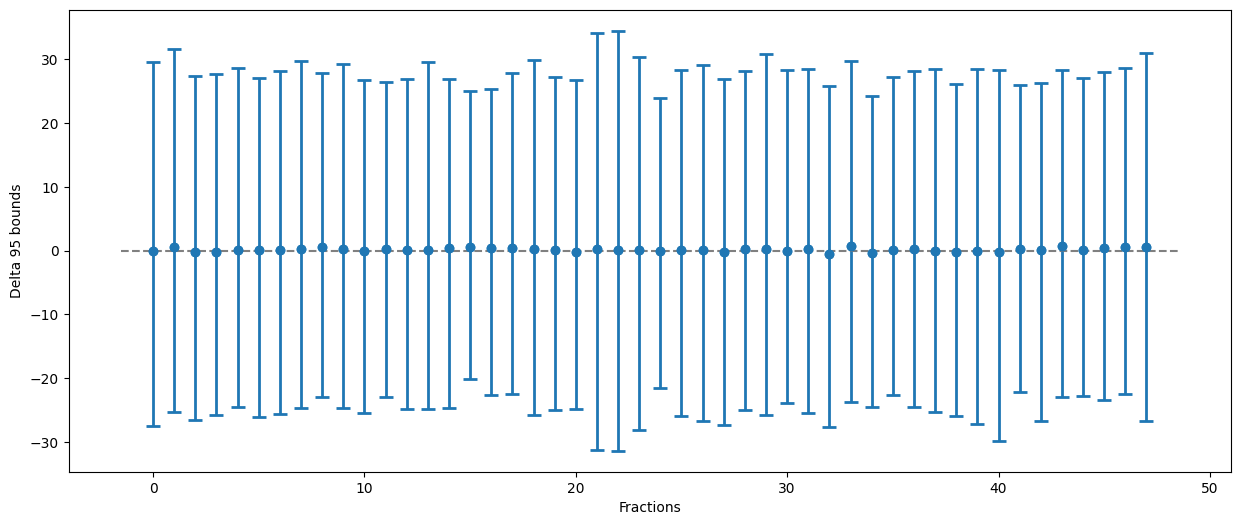

In [12]:
# 51 wit 30%
df = result_51
df['error_lower'] = df['Mean'] - df['Lower bound']
df['error_upper'] = df['Upper bound'] - df['Mean']

# Plot setup
plt.figure(figsize=(15, 6))

# Plotting the error bars
plt.errorbar(x=range(len(df)), y=df['Mean'], 
             yerr=[df['error_lower'], df['error_upper']], 
             fmt='o', capsize=5, capthick=2,   elinewidth=2)#ecolor='gray',color='blue',
plt.scatter(x= range(len(df)), y=df['Mean'],  label='CCS prediction', zorder=5)
# Customize the plot
plt.xlabel('Fractions')
plt.ylabel('Delta 95 bounds')
plt.grid(False)
plt.hlines(y = 0.0, xmin = -1.5, xmax= 48.5, linestyles='--', colors='grey')
plt.show()

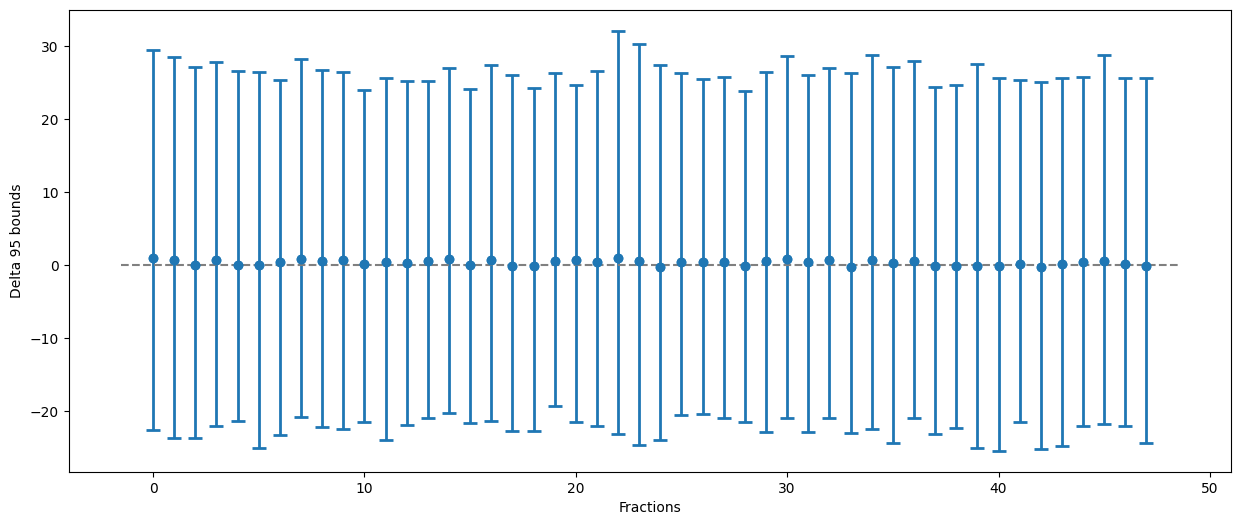

In [14]:
df = result_64
df['error_lower'] = df['Mean'] - df['Lower bound']
df['error_upper'] = df['Upper bound'] - df['Mean']

# Plot setup
plt.figure(figsize=(15, 6))

# Plotting the error bars
plt.errorbar(x=range(len(df)), y=df['Mean'], 
             yerr=[df['error_lower'], df['error_upper']], 
             fmt='o', capsize=5, capthick=2,  elinewidth=2)
plt.scatter(x= range(len(df)), y=df['Mean'],  label='CCS prediction', zorder=5)
# Customize the plot
plt.xlabel('Fractions')
plt.ylabel('Delta 95 bounds')
plt.grid(False)
plt.hlines(y = 0.0, xmin = -1.5, xmax= 48.5, linestyles='--', colors='grey')
plt.show()

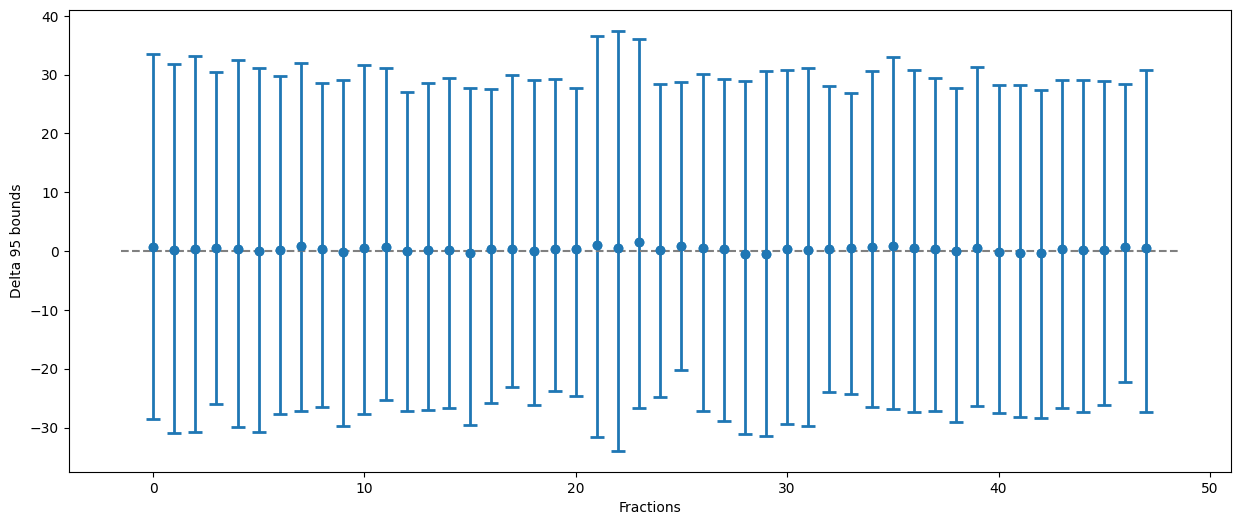

In [17]:
df = result_28
df['error_lower'] = df['Mean'] - df['Lower bound']
df['error_upper'] = df['Upper bound'] - df['Mean']

# Plot setup
plt.figure(figsize=(15, 6))

# Plotting the error bars
plt.errorbar(x=range(len(df)), y=df['Mean'], 
             yerr=[df['error_lower'], df['error_upper']], 
             fmt='o', capsize=5, capthick=2,   elinewidth=2)
plt.scatter(x= range(len(df)), y=df['Mean'], label='CCS prediction', zorder=5)
# Customize the plot
plt.xlabel('Fractions')
plt.ylabel('Delta 95 bounds')
plt.grid(False)
plt.hlines(y = 0.0, xmin = -1.5, xmax= 48.5, linestyles='--', colors='grey')
plt.show()

In [7]:
result_51['Source'] = 'P064051'
result_64['Source'] = 'P064064'
result_28['Source'] = 'P064428'
df_trans = pd.concat([result_51, result_64, result_28],ignore_index=True)

In [17]:
result_51['Source'] = '51_20'
result_51_30['Source'] = '51_30'
df_trans = pd.concat([result_51, result_51_30],ignore_index=True)

In [8]:
df_trans.shape

(144, 5)

Text(0.5, 0, 'Window size')

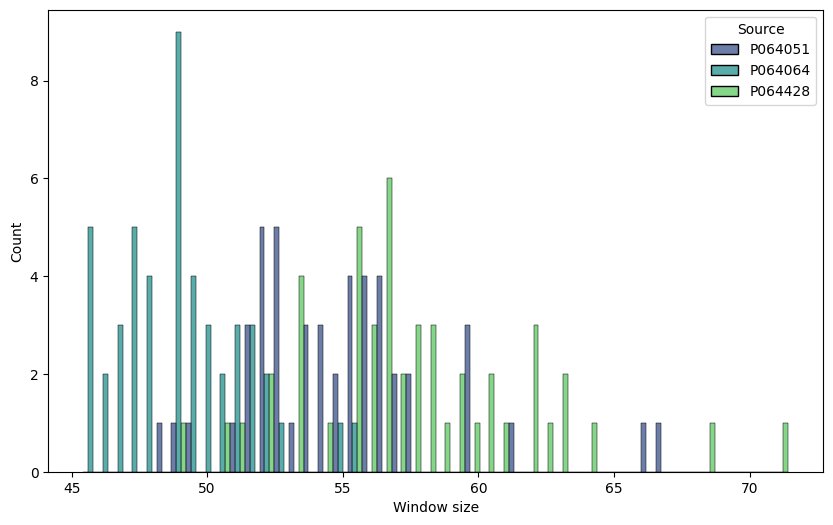

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(x=df_trans['Window'],hue=df_trans['Source'], multiple='dodge', palette='viridis', bins = 48)
plt.xlabel('Window size')

Text(0.5, 0, 'Window size')

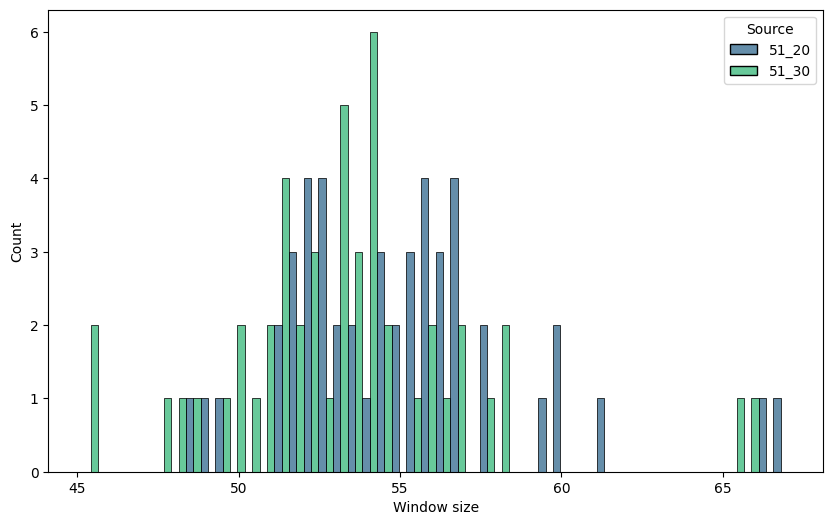

In [18]:
# camparison 20% to 30%
plt.figure(figsize=(10, 6))
sns.histplot(x=df_trans['Window'],hue=df_trans['Source'], multiple='dodge', palette='viridis', bins = 48)
plt.xlabel('Window size')

# Charge

In [5]:
# generate training set
# discard Charge 1, because of too few measurements
df = df_base
n = 50000

df_2 = df[df['Charge']==2].sample(n = n, random_state =  42)
df_3 = df[df['Charge']==3].sample(n = n, random_state = 42)
df_4 = df[df['Charge']==4].sample(n=n, random_state = 42)

df_train = pd.concat(objs=[df_2, df_3, df_4])
print(len(df_train))

150000


In [6]:
# turn training df into alpha base format
df_train.loc[:,'Original index'] = df_train.index
# run AlphaBase
mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.column_mapping['Original index'] = 'Original index'
mq_reader._translate_columns(df_train)
mq_reader._transform_table(df_train)
mq_reader._translate_decoy(df_train)
mq_reader._translate_score(df_train)
mq_reader._load_modifications(df_train)
mq_reader._translate_modifications()
mq_reader._post_process(df_train)  
df_train_ab = mq_reader.psm_df

In [7]:
models = ModelManager(device = 'gpu')
models.load_installed_models()

c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\cuda\__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
models.train_ccs_model(df_train_ab)

2024-08-14 14:08:20> 82246 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [9]:
# turn training df into alpha base format
df_mq = df_base
df_mq.loc[:,'Original index'] = df_mq.index
# run AlphaBase
mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.column_mapping['Original index'] = 'Original index'
mq_reader._translate_columns(df_mq)
mq_reader._transform_table(df_mq)
mq_reader._translate_decoy(df_mq)
mq_reader._translate_score(df_mq)
mq_reader._load_modifications(df_mq)
mq_reader._translate_modifications()
mq_reader._post_process(df_mq)  
df_ab = mq_reader.psm_df

In [10]:
# predict whole dataset
prediction = models.predict_mobility(df_ab)

2024-08-14 15:35:05> Predicting mobility ...


100%|██████████| 46/46 [08:23<00:00, 10.96s/it]


In [11]:
prediction.to_csv('predictions/pred_trans_charge.txt', sep = '\t')

In [12]:
# merging alpha base format back to MaxQuant
#df_ab = pd.read_csv('comparisons/comp_all_trans.txt', sep = '\t')
df_ab = prediction
df_comp = df_base
df_comp['ccs_pred'] = df_ab['ccs_pred']
df_comp['mobility_pred'] = df_ab['mobility_pred']
mapping_dict = {
            'sequence': 'Sequence',
            'charge': 'Charge',
            'rt': 'Retention time',
            'ccs': 'CCS',
            'mobility': '1/K0',
            'scan_num': 'MS/MS scan number',
            'raw_name': 'Raw file',
            'precursor_mz': 'm/z',
            'score': 'Score',
            'proteins': 'Proteins',
            'genes': 'Gene names',
            'decoy': 'Reverse',
            'intensity': 'Intensity',
            'nAA':'Length'}
merging_list = ['Sequence', 'Charge', 'CCS', 'Score', 'Length', 'Retention time', 'Proteins', 'Gene names','1/K0' , 'MS/MS scan number', 'Raw file'
                                                  , 'm/z', 'Intensity' ]
        # rename the columns of the alphabase dataframe according to the mapping dict
df_ab.rename(columns=mapping_dict, inplace=True)
        # set the original index as index
#df_ab.set_index('Original index', inplace=True)
df_merged = pd.merge( df_comp,df_ab, on = merging_list, how = 'inner')
#df_merged.to_csv('comparisons/comp_trans_v2_orig.txt', sep = '\t')

In [13]:
df_merged.shape

(1396568, 82)

In [ ]:
df_comp = pd.read_csv('comparisons/comp_trans_orig.txt', sep = '\t')

C:\Users\cocob\AppData\Local\Temp\ipykernel_1724\4069564456.py:1: DtypeWarning: Columns (62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comp = pd.read_csv('comparisons/comp_trans_orig.txt', sep = '\t')


In [14]:
df_comp = df_merged

In [15]:
df_comp['ccs_diff'] = np.subtract(df_comp['CCS'], df_comp['ccs_pred_y'])
df_comp['IM_diff'] = np.subtract(df_comp['1/K0'], df_comp['mobility_pred_y'])

2024-08-15 09:41:00> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


C:\Users\cocob\AppData\Local\Temp\ipykernel_19396\2118696814.py:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x='Charge', y='ccs_diff', data=df_comp, scale='count')#inner='box',


2024-08-15 09:41:01> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


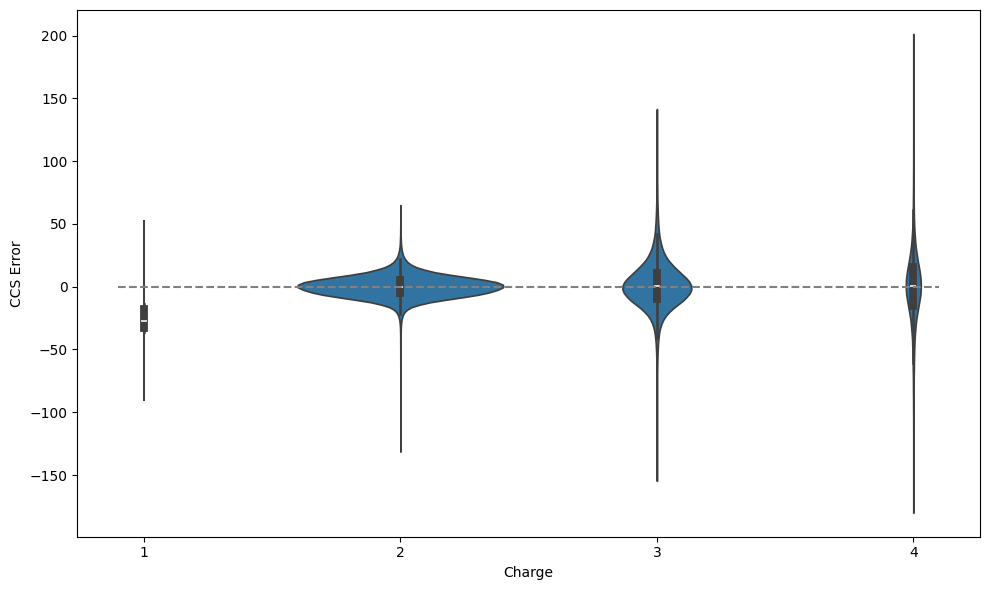

CCS:
-22.085611694219562
23.128394993725976
0.1843800241223339
8.898053751312053
1.141721143810288
19.33172743485177
-0.398704173310816
29.81360528645308
IM:
-0.10885232238130259
0.1138329733888796
0.0004557984601426119
0.02202286286970948
0.0018898820804959064
0.031996107376034984
-0.0004948745369284706
0.03706345444764517


In [25]:
# violin plot: charge vs CCS error
plt.figure(figsize=(10, 6))
sns.violinplot(x='Charge', y='ccs_diff', data=df_comp, scale='count')#inner='box',

# Set plot labels and title
plt.xlabel('Charge')
plt.ylabel('CCS Error')
plt.hlines(y = 0.0, xmin = -0.1, xmax= 3.1, linestyles='--', colors='grey')
plt.tight_layout()

# Display the plot
plt.show()
print('CCS:')
print(df_comp[df_comp['Charge']==1]['ccs_diff'].mean())
print(df_comp[df_comp['Charge']==1]['ccs_diff'].std())
print(df_comp[df_comp['Charge']==2]['ccs_diff'].mean())
print(df_comp[df_comp['Charge']==2]['ccs_diff'].std())
print(df_comp[df_comp['Charge']==3]['ccs_diff'].mean())
print(df_comp[df_comp['Charge']==3]['ccs_diff'].std())
print(df_comp[df_comp['Charge']==4]['ccs_diff'].mean())
print(df_comp[df_comp['Charge']==4]['ccs_diff'].std())
print('IM:')
print(df_comp[df_comp['Charge']==1]['IM_diff'].mean())
print(df_comp[df_comp['Charge']==1]['IM_diff'].std())
print(df_comp[df_comp['Charge']==2]['IM_diff'].mean())
print(df_comp[df_comp['Charge']==2]['IM_diff'].std())
print(df_comp[df_comp['Charge']==3]['IM_diff'].mean())
print(df_comp[df_comp['Charge']==3]['IM_diff'].std())
print(df_comp[df_comp['Charge']==4]['IM_diff'].mean())
print(df_comp[df_comp['Charge']==4]['IM_diff'].std())

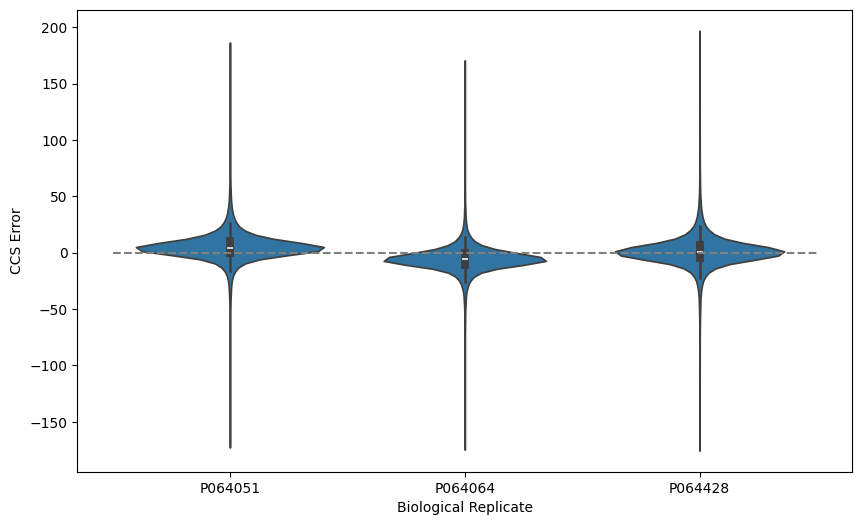

5.069241440810234
-5.7070322682040695
1.0133446398478427


In [26]:
# violin plot: experiment vs CCS error
plt.figure(figsize=(10, 6))
sns.violinplot(x='Experiment', y='ccs_diff', data=df_comp, density_norm='count')

# Set plot labels and title
plt.xlabel('Biological Replicate')
plt.ylabel('CCS Error')
plt.hlines(y = 0.0, xmin = -0.5, xmax= 2.5, linestyles='--', colors='grey')

# Display the plot
plt.show()
print(df_comp[df_comp['Experiment']=='P064051']['ccs_diff'].mean())
print(df_comp[df_comp['Experiment']=='P064064']['ccs_diff'].mean())
print(df_comp[df_comp['Experiment']=='P064428']['ccs_diff'].mean())

Text(0.5, 1.0, 'Adjusted Error(Transfer Learning)')

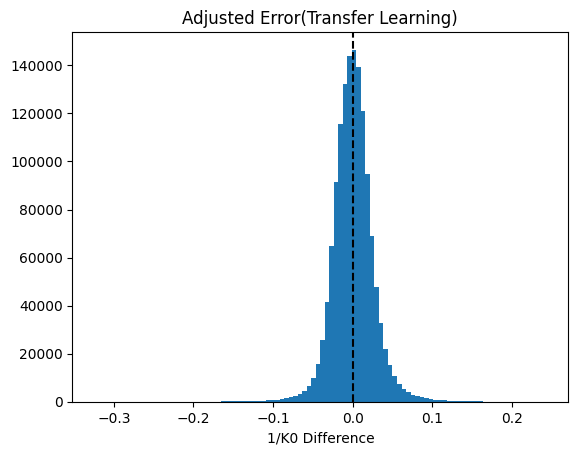

In [18]:
plt.hist(df_comp['IM_diff'], bins=100)
plt.axvline(x = 0.0, c = 'black', linestyle = '--')
plt.xlabel('1/K0 Difference')
plt.title('Adjusted Error(Transfer Learning)')

In [19]:
print(df_comp['ccs_diff'].mean())
print(df_comp['ccs_diff'].std())

0.38234045559905694
13.83251955299541


In [ ]:
print(df_pred['ccs_diff'].abs().mean())

9.791640217897543


In [20]:
# percentile of CCS Difference
perc_low = np.percentile(df_comp['ccs_diff'], 2.5)
perc_up = np.percentile(df_comp['ccs_diff'], 97.5)
print(f'({perc_low}, {perc_up})')


(-25.289257646646508, 28.73420834028229)


In [21]:
print((perc_low)*(-1)+perc_up)
window = (perc_low)*(-1)+perc_up

54.0234659869288


In [22]:
print(df_comp['IM_diff'].mean())
print(df_comp['IM_diff'].std())


0.000747760374945111
0.025688232603816905


In [23]:
# percentile of IM Difference
perc_low = np.percentile(df_comp['IM_diff'], 2.5)
perc_up = np.percentile(df_comp['IM_diff'], 97.5)
print(f'({perc_low}, {perc_up})')


(-0.04653890793126054, 0.05323631867326837)


In [24]:
print((perc_low)*(-1)+perc_up)
window = (perc_low)*(-1)+perc_up

0.09977522660452891


# AlphaPeptDeep Training Set

In [5]:
df_lys = pd.read_csv('orig_trainset/Hela_lys/evidence.txt', sep ='\t')

In [6]:
df_tryp = pd.read_csv('orig_trainset/Hela_trypsin/evidence.txt', sep = '\t')

C:\Users\cocob\AppData\Local\Temp\ipykernel_4516\1340216300.py:1: DtypeWarning: Columns (59) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tryp = pd.read_csv('orig_trainset/Hela_trypsin/evidence.txt', sep = '\t')


In [38]:
print(df_lys.shape)
print(df_tryp.shape)

(209472, 71)
(352110, 69)


In [7]:
df_train = pd.concat([df_lys, df_tryp], axis = 0)

In [41]:
print(df_train.shape)

(561582, 73)


In [43]:
print(f"Charge 1:{len(df_train[df_train['Charge']==1])}")
print(f"Charge 2:{len(df_train[df_train['Charge']==2])}")
print(f"Charge 3:{len(df_train[df_train['Charge']==3])}")
print(f"Charge 4:{len(df_train[df_train['Charge']==4])}")
print(f"Charge 5:{len(df_train[df_train['Charge']==5])}")

Charge 1:1987
Charge 2:371275
Charge 3:159136
Charge 4:29184
Charge 5:0


In [44]:
print(df_train['Charge'].unique())

[2 3 4 1]


(array([2.6000e+03, 8.3680e+03, 1.7533e+04, 2.6244e+04, 0.0000e+00,
        3.5268e+04, 4.1794e+04, 4.4161e+04, 4.4427e+04, 0.0000e+00,
        4.4747e+04, 4.2712e+04, 3.9329e+04, 3.3223e+04, 0.0000e+00,
        3.2587e+04, 2.7053e+04, 2.2585e+04, 1.8538e+04, 0.0000e+00,
        1.5463e+04, 1.2535e+04, 1.0975e+04, 7.8460e+03, 0.0000e+00,
        6.7040e+03, 5.1100e+03, 4.5910e+03, 3.3820e+03, 0.0000e+00,
        2.7250e+03, 2.3340e+03, 1.7510e+03, 1.5730e+03, 0.0000e+00,
        1.1890e+03, 9.3100e+02, 7.8600e+02, 9.6200e+02, 0.0000e+00,
        4.0700e+02, 2.7800e+02, 2.9800e+02, 2.3300e+02, 0.0000e+00,
        8.5000e+01, 4.3000e+01, 7.8000e+01, 3.8000e+01, 0.0000e+00,
        2.5000e+01, 4.0000e+00, 1.7000e+01, 0.0000e+00, 0.0000e+00,
        3.0000e+01, 1.8000e+01, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([ 7. ,  7.8,  8.6,  9.4, 10.2, 11. , 11.8, 12.6, 13.4, 14.2, 15. ,
        15.8, 16.6, 17.4, 18.2, 19. , 19.8, 20.6, 21.4, 22.2, 23. , 23.8,
        24.6, 25.4, 26.2, 27. , 27

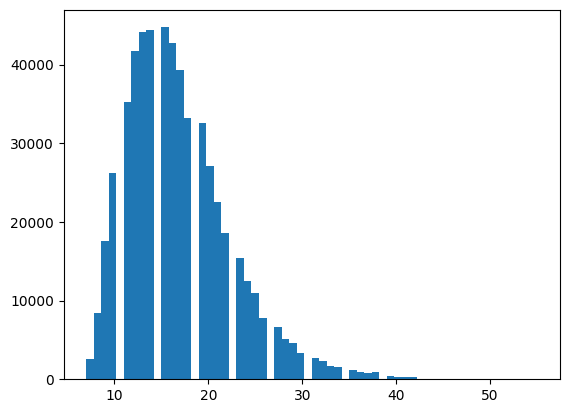

In [6]:
plt.hist(x = df_train['Length'], bins = 60)

In [7]:
print(df_train['Length'].max())

55


In [8]:
# range CCS
print(df_train['CCS'].min())
print(df_train['CCS'].max())
print(df_train['CCS'].max()-df_train['CCS'].min())

151.952546762941
1126.84836110592
974.8958143429791


In [11]:
# range 1/K0
print(df_train['K0'].min())
print(df_train['K0'].max())
print(df_train['K0'].max()-df_train['K0'].min())

0.682220735455878
1.4928798181462
0.8106590826903219


In [10]:
print(df_train.columns)

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages (LysC/P)',
       'Missed cleavages (LysN)', 'Proteins', 'Leading proteins',
       'Leading razor protein', 'Gene names', 'Protein names', 'Type',
       'Raw file', 'Experiment', 'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Resolution', 'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', 'K0', 'K0 length', 'Calibrated K0', 'CCS',
       'CCS length', 'Match time difference', 'M